In [1]:
import math 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import os


import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from time import time

import warnings

import random

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action = 'ignore')

In [2]:
SEED = 123
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_everything(SEED)

In [3]:
device = 'cuda'

In [4]:
def load_data_1m(path='./', delimiter='::', frac=0.1, seed=1234):

    tic = time()
    print('reading data...')
    data = np.loadtxt(path+'ratings.dat', skiprows=0, delimiter=delimiter, encoding='latin-1').astype('int32')
    print(data)
#     print(data[data[:,2] == 0])
    print('taken', time() - tic, 'seconds')

    n_u = np.unique(data[:,0]).size  # num of users
    n_m = np.unique(data[:,1]).size  # num of movies
    n_r = data.shape[0]  # num of ratings

    udict = {}
    for i, u in enumerate(np.unique(data[:,0]).tolist()):
        udict[u] = i
    mdict = {}
    for i, m in enumerate(np.unique(data[:,1]).tolist()):
        mdict[m] = i

    np.random.seed(seed)
    idx = np.arange(n_r)
    np.random.shuffle(idx)

    train_r = np.zeros((n_m, n_u), dtype='float32')
    test_r = np.zeros((n_m, n_u), dtype='float32')
    train_user = []
    train_item = []
    train_rating = []
    test_user = []
    test_item = []
    test_rating = []
    
    for i in range(n_r):
        u_id = data[idx[i], 0]
        m_id = data[idx[i], 1]
        r = data[idx[i], 2]

        if i < int(frac * n_r):
            test_r[mdict[m_id], udict[u_id]] = r
            test_user.append(udict[u_id])
            test_item.append(mdict[m_id])
            test_rating.append(r)
            
        else:
            train_r[mdict[m_id], udict[u_id]] = r
            train_user.append(udict[u_id])
            train_item.append(mdict[m_id])
            train_rating.append(r)

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')
    train_user = np.array(train_user).astype('float32') 
    train_item = np.array(train_item).astype('float32')
    train_rating = np.array(train_rating).astype('float32')
    test_user = np.array(test_user).astype('float32') 
    test_item = np.array(test_item).astype('float32') 
    test_rating = np.array(test_rating).astype('float32')
    
    
    
    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_r - int(frac * n_r)))
    print('num of test ratings: {}'.format(int(frac * n_r)))

    return n_m, n_u, train_r, train_m, test_r, test_m, train_user, train_item, train_rating, test_user, test_item, test_rating

In [5]:
path = '/Linux/Data/recommendation/ml-10m/'
n_m, n_u, train_r, train_m, test_r, test_m, train_user, train_item, train_rating, test_user, test_item, test_rating = load_data_1m(path=path, delimiter='::', frac=0.1, seed=1234)


reading data...
[[        1       122         5 838985046]
 [        1       185         5 838983525]
 [        1       231         5 838983392]
 ...
 [    71567      2294         5 912577968]
 [    71567      2338         2 912578016]
 [    71567      2384         2 912578173]]
taken 54.00359129905701 seconds
data matrix loaded
num of users: 69878
num of movies: 10677
num of training ratings: 9000049
num of test ratings: 1000005


In [6]:
items = torch.LongTensor(train_item)
users = torch.LongTensor(train_user)
ratings = torch.FloatTensor(train_rating)
items_test = torch.LongTensor(test_item)
users_test = torch.LongTensor(test_user)
ratings_test = torch.FloatTensor(test_rating)

In [7]:
len(items), len(users), len(ratings)

(9000049, 9000049, 9000049)

In [8]:
# rank = 10

numItems = 10677
numUsers = 69878

# P = torch.randn(numItems, rank, requires_grad=True)
# Q = torch.randn(numUsers, rank, requires_grad=True)

In [9]:
n_gaussians = 1
# n_hidden = 128
rank = 20
# reg_p = [1/n_gaussians] * n_gaussians
# reg_p = [0.8, 0.2]

In [10]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

In [11]:
def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * F.softmax(pi)
    result = torch.sum(result, dim=1)
    result = -torch.log(result+ 1e-6)
    return torch.mean(result)

In [12]:
# def regularization(p, k):
#     minus = torch.zeros(1,k)
#     result = []
#     for i in range(k):
#         minus[:,i] = 1
#         result.append(torch.mean(F.softmax(p), axis = 0) - minus)
#         minus = torch.zeros(1,k)
#     result = torch.sum(torch.square(torch.cat(result)))
#     return result

In [13]:
def regularization(p, k):
    result = torch.mean(F.softmax(p), axis = 0) - torch.Tensor(k).to(device)
    result = torch.sum(torch.square(result))
    return result

In [14]:
import torch
import torch.nn as nn

class PosLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(PosLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn((in_dim, out_dim)))
        self.bias = nn.Parameter(torch.zeros((out_dim,)))
        
    def forward(self, x):
        return torch.matmul(x, torch.abs(self.weight)) + torch.abs(self.bias)

In [15]:
layers_mean = PosLinear(rank, n_gaussians).to(device)
# layers_mean = nn.Sequential(
#             nn.Linear(rank, 128),
#             nn.Tanh(),
#             nn.Linear(128, n_gaussians)
# ).to(device)
# layers_mean = nn.Sequential(
#             PosLinear(rank, 128),
#             PosLinear(128, n_gaussians)
# ).to(device)
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)


In [16]:
P.shape, Q.shape

(torch.Size([10677, 20]), torch.Size([69878, 20]))

In [17]:
# lambda1 = 0.0001
# lambda2 = 0.0001
# lambda3 = 0.1
# optimizer_P = torch.optim.Adam([P] + list(layers_mean.parameters()), lr= 1e-3)
# optimizer_Q = torch.optim.Adam([Q] + list(layers_mean.parameters()), lr= 1e-3)

In [18]:
# bias_item = torch.randn(numItems, requires_grad = True)
# bias_user = torch.randn(numUsers, requires_grad = True)

In [19]:
# mean = (ratings.sum()/len(ratings)).item()

In [20]:
bi = torch.nn.Parameter(torch.randn(numItems, requires_grad = True))
bu = torch.nn.Parameter(torch.randn(numUsers, requires_grad = True))

epoch: 0, train cost_P 12.887558, train cost_Q: 12.875249, train cost: 3.588210, test cost: 3.589128, minimum test cost: 3.589128
means of test groups: tensor([[-0.0477],
        [ 0.4741],
        [-0.0181],
        [ 0.2272],
        [-0.0678]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 2., 3.])


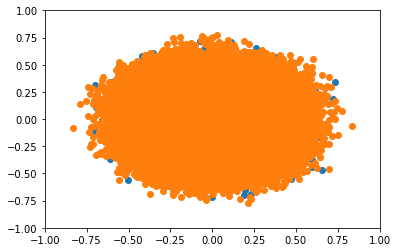

epoch: 100, train cost_P 1.392622, train cost_Q: 1.392334, train cost: 1.179972, test cost: 1.180751, minimum test cost: 1.180751
means of test groups: tensor([[2.8927],
        [2.8685],
        [2.8510],
        [2.9021],
        [2.9182]], device='cuda:0')
ratings of test groups: tensor([2., 4., 2., 4., 5.])


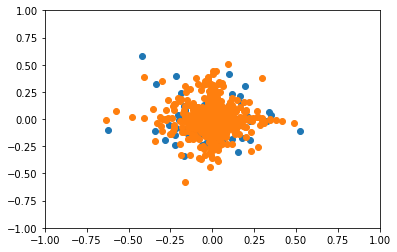

epoch: 200, train cost_P 1.296647, train cost_Q: 1.296537, train cost: 1.138656, test cost: 1.139956, minimum test cost: 1.139956
means of test groups: tensor([[2.9782],
        [2.9505],
        [2.9948],
        [2.0320],
        [2.7071]], device='cuda:0')
ratings of test groups: tensor([4., 2., 4., 3., 1.])


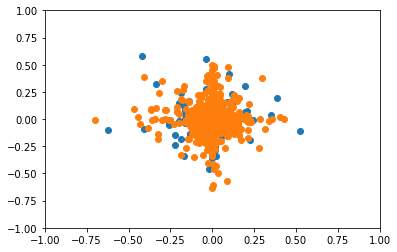

epoch: 300, train cost_P 1.228880, train cost_Q: 1.228782, train cost: 1.108504, test cost: 1.110167, minimum test cost: 1.110167
means of test groups: tensor([[2.8855],
        [2.8349],
        [3.0563],
        [2.8269],
        [3.0588]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 3., 4.])


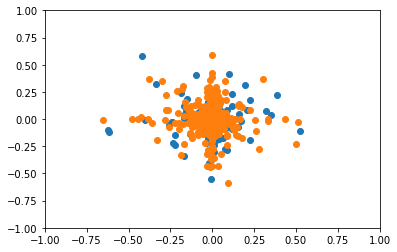

epoch: 400, train cost_P 1.171036, train cost_Q: 1.170950, train cost: 1.082104, test cost: 1.084119, minimum test cost: 1.084119
means of test groups: tensor([[2.9280],
        [3.1115],
        [2.3355],
        [3.1227],
        [3.1236]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 4., 4.])


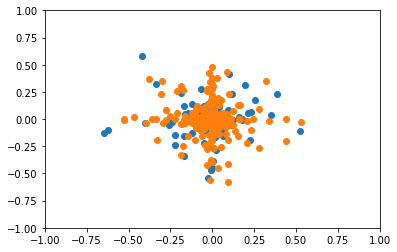

epoch: 500, train cost_P 1.120943, train cost_Q: 1.120868, train cost: 1.058711, test cost: 1.061096, minimum test cost: 1.061096
means of test groups: tensor([[3.1837],
        [3.1821],
        [3.1718],
        [3.1823],
        [3.1622]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 4., 5.])


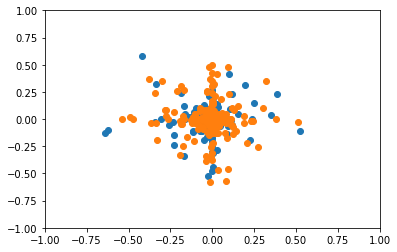

epoch: 600, train cost_P 1.077240, train cost_Q: 1.077174, train cost: 1.037870, test cost: 1.040660, minimum test cost: 1.040660
means of test groups: tensor([[3.1889],
        [2.9332],
        [3.2398],
        [3.2384],
        [2.7238]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 5., 2.])


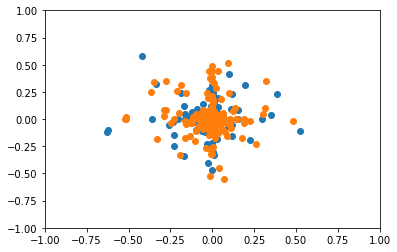

epoch: 700, train cost_P 1.038935, train cost_Q: 1.038877, train cost: 1.019253, test cost: 1.022477, minimum test cost: 1.022477
means of test groups: tensor([[3.2931],
        [3.1936],
        [3.2932],
        [3.2910],
        [3.2073]], device='cuda:0')
ratings of test groups: tensor([4., 2., 4., 4., 3.])


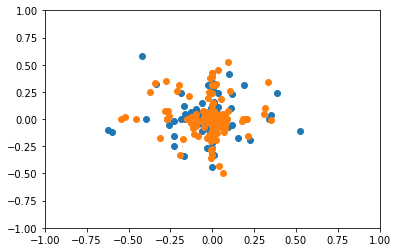

epoch: 800, train cost_P 1.005230, train cost_Q: 1.005178, train cost: 1.002586, test cost: 1.006273, minimum test cost: 1.006273
means of test groups: tensor([[2.3978],
        [3.3195],
        [3.3409],
        [3.3052],
        [2.8497]], device='cuda:0')
ratings of test groups: tensor([2., 4., 5., 3., 1.])


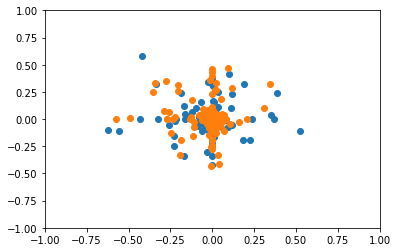

epoch: 900, train cost_P 0.975451, train cost_Q: 0.975404, train cost: 0.987625, test cost: 0.991800, minimum test cost: 0.991800
means of test groups: tensor([[1.8258],
        [3.3447],
        [3.0717],
        [3.3407],
        [2.8751]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 4., 3.])


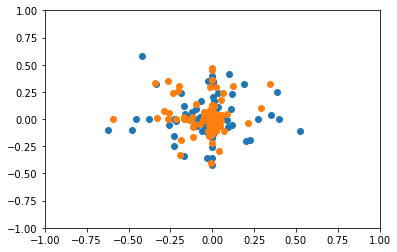

epoch: 1000, train cost_P 0.949037, train cost_Q: 0.948994, train cost: 0.974163, test cost: 0.978844, minimum test cost: 0.978844
means of test groups: tensor([[3.2985],
        [3.4117],
        [2.2210],
        [3.4461],
        [3.3618]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 5., 5.])


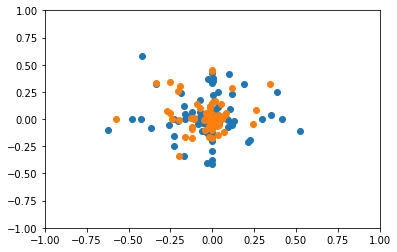

epoch: 1100, train cost_P 0.925517, train cost_Q: 0.925477, train cost: 0.962017, test cost: 0.967235, minimum test cost: 0.967235
means of test groups: tensor([[3.4862],
        [3.4799],
        [3.2589],
        [2.9986],
        [2.8435]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 4., 4.])


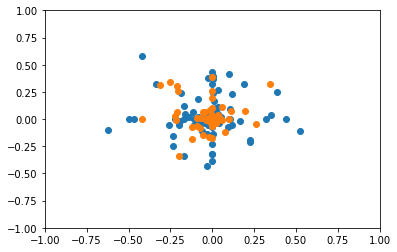

epoch: 1200, train cost_P 0.904483, train cost_Q: 0.904446, train cost: 0.951024, test cost: 0.956808, minimum test cost: 0.956808
means of test groups: tensor([[3.3862],
        [3.5254],
        [2.8676],
        [3.5323],
        [3.1174]], device='cuda:0')
ratings of test groups: tensor([5., 4., 3., 5., 4.])


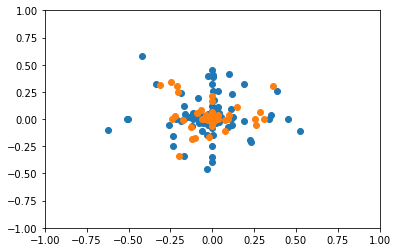

epoch: 1300, train cost_P 0.885587, train cost_Q: 0.885550, train cost: 0.941037, test cost: 0.947419, minimum test cost: 0.947403
means of test groups: tensor([[2.8524],
        [3.4987],
        [3.2970],
        [2.7426],
        [2.8739]], device='cuda:0')
ratings of test groups: tensor([2., 4., 5., 1., 2.])


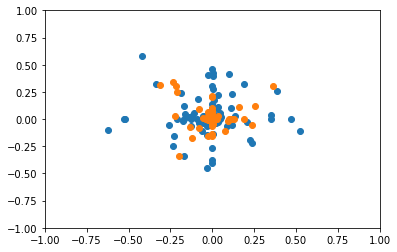

epoch: 1400, train cost_P 0.868534, train cost_Q: 0.868497, train cost: 0.931932, test cost: 0.938927, minimum test cost: 0.938894
means of test groups: tensor([[3.0581],
        [3.5686],
        [3.1371],
        [3.6201],
        [2.5969]], device='cuda:0')
ratings of test groups: tensor([1., 4., 3., 4., 3.])


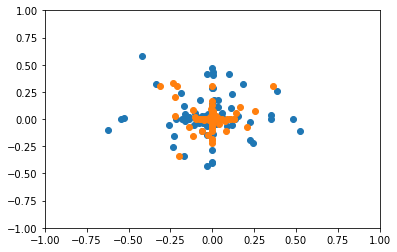

epoch: 1500, train cost_P 0.853085, train cost_Q: 0.853046, train cost: 0.923605, test cost: 0.931241, minimum test cost: 0.931174
means of test groups: tensor([[3.1062],
        [2.8308],
        [3.6487],
        [3.2790],
        [3.5233]], device='cuda:0')
ratings of test groups: tensor([3., 3., 4., 3., 5.])


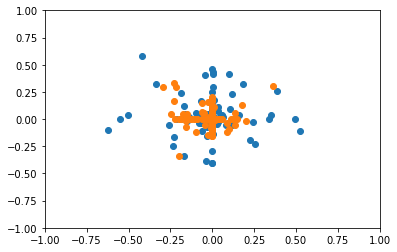

epoch: 1600, train cost_P 0.839015, train cost_Q: 0.838971, train cost: 0.915953, test cost: 0.924261, minimum test cost: 0.924159
means of test groups: tensor([[3.5667],
        [3.2999],
        [3.0235],
        [3.4687],
        [3.0974]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 3., 4.])


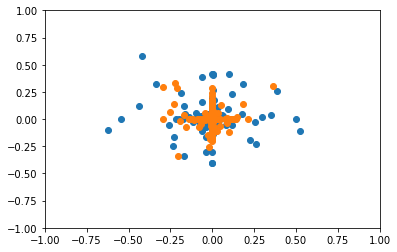

epoch: 1700, train cost_P 0.826153, train cost_Q: 0.826104, train cost: 0.908902, test cost: 0.917881, minimum test cost: 0.917736
means of test groups: tensor([[2.5835],
        [3.5342],
        [3.4451],
        [3.3777],
        [1.9948]], device='cuda:0')
ratings of test groups: tensor([2., 3., 3., 4., 1.])


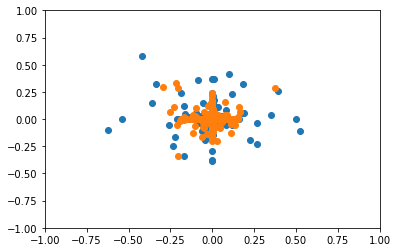

epoch: 1800, train cost_P 0.814342, train cost_Q: 0.814288, train cost: 0.902379, test cost: 0.912056, minimum test cost: 0.911860
means of test groups: tensor([[3.7532],
        [3.7112],
        [3.3690],
        [3.3727],
        [3.2045]], device='cuda:0')
ratings of test groups: tensor([5., 5., 3., 2., 4.])


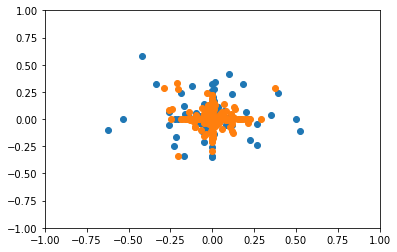

epoch: 1900, train cost_P 0.803439, train cost_Q: 0.803375, train cost: 0.896312, test cost: 0.906709, minimum test cost: 0.906450
means of test groups: tensor([[1.6446],
        [3.6140],
        [2.9484],
        [3.2995],
        [1.6163]], device='cuda:0')
ratings of test groups: tensor([2., 4., 2., 3., 1.])


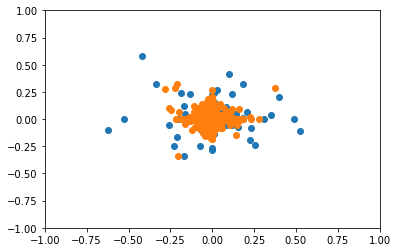

epoch: 2000, train cost_P 0.793343, train cost_Q: 0.793268, train cost: 0.890656, test cost: 0.901787, minimum test cost: 0.901432
means of test groups: tensor([[3.2147],
        [3.6104],
        [3.6754],
        [3.4999],
        [3.4770]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 3., 3.])


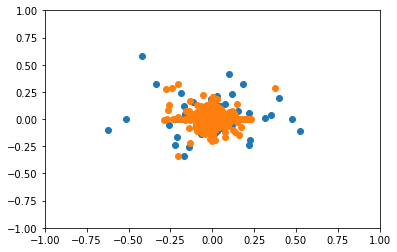

epoch: 2100, train cost_P 0.783967, train cost_Q: 0.783884, train cost: 0.885372, test cost: 0.897270, minimum test cost: 0.896761
means of test groups: tensor([[2.8946],
        [3.6838],
        [3.4650],
        [3.4186],
        [3.4332]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 2., 4.])


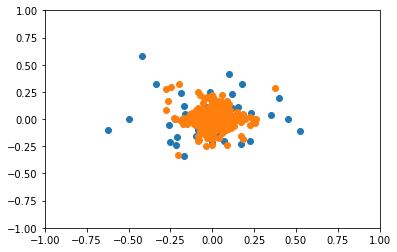

epoch: 2200, train cost_P 0.775240, train cost_Q: 0.775147, train cost: 0.880424, test cost: 0.893078, minimum test cost: 0.892407
means of test groups: tensor([[3.1339],
        [3.7972],
        [3.5086],
        [3.7423],
        [3.8965]], device='cuda:0')
ratings of test groups: tensor([3., 3., 4., 5., 5.])


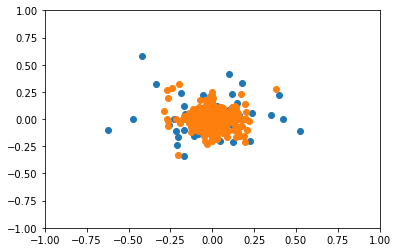

epoch: 2300, train cost_P 0.767050, train cost_Q: 0.766950, train cost: 0.875757, test cost: 0.889168, minimum test cost: 0.888369
means of test groups: tensor([[3.9066],
        [2.5572],
        [2.7970],
        [3.3203],
        [3.3296]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 3., 4.])


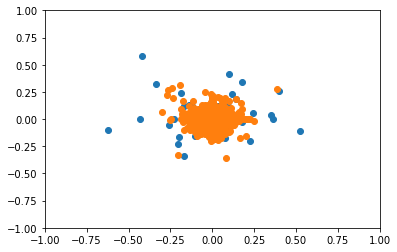

epoch: 2400, train cost_P 0.759410, train cost_Q: 0.759305, train cost: 0.871381, test cost: 0.885572, minimum test cost: 0.884589
means of test groups: tensor([[3.7007],
        [3.1106],
        [3.6459],
        [2.9660],
        [2.8664]], device='cuda:0')
ratings of test groups: tensor([4., 1., 4., 2., 3.])


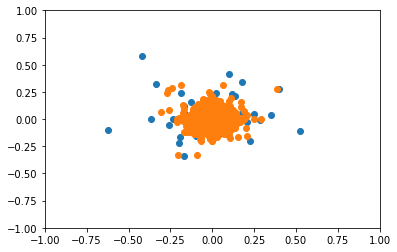

epoch: 2500, train cost_P 0.752172, train cost_Q: 0.752060, train cost: 0.867214, test cost: 0.882176, minimum test cost: 0.881067
means of test groups: tensor([[3.4326],
        [2.1951],
        [3.7696],
        [1.1880],
        [2.4304]], device='cuda:0')
ratings of test groups: tensor([4., 2., 5., 0., 3.])


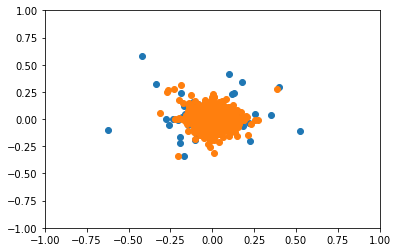

epoch: 2600, train cost_P 0.745408, train cost_Q: 0.745292, train cost: 0.863303, test cost: 0.879059, minimum test cost: 0.877738
means of test groups: tensor([[3.1786],
        [3.3758],
        [2.8530],
        [3.1414],
        [3.7201]], device='cuda:0')
ratings of test groups: tensor([5., 3., 3., 3., 3.])


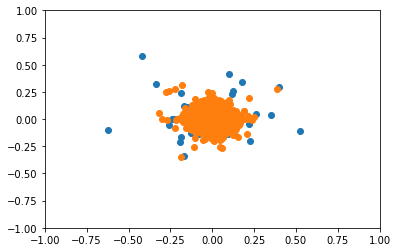

epoch: 2700, train cost_P 0.738983, train cost_Q: 0.738874, train cost: 0.859578, test cost: 0.876063, minimum test cost: 0.874590
means of test groups: tensor([[3.6690],
        [4.0451],
        [3.4645],
        [3.2999],
        [3.4308]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 5., 4.])


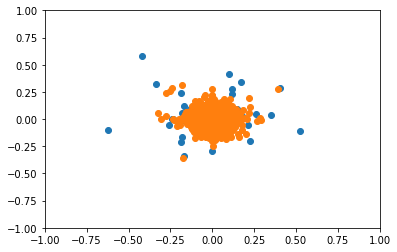

epoch: 2800, train cost_P 0.732901, train cost_Q: 0.732796, train cost: 0.856035, test cost: 0.873288, minimum test cost: 0.871612
means of test groups: tensor([[1.2596],
        [3.6153],
        [4.1254],
        [3.2493],
        [2.4080]], device='cuda:0')
ratings of test groups: tensor([1., 4., 5., 4., 3.])


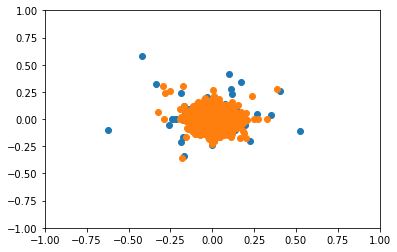

epoch: 2900, train cost_P 0.726832, train cost_Q: 0.726732, train cost: 0.852486, test cost: 0.870523, minimum test cost: 0.868776
means of test groups: tensor([[3.2656],
        [3.6198],
        [3.1251],
        [3.4097],
        [2.9630]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 3., 3.])


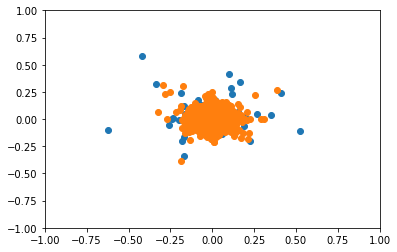

epoch: 3000, train cost_P 0.721178, train cost_Q: 0.721079, train cost: 0.849164, test cost: 0.867962, minimum test cost: 0.866097
means of test groups: tensor([[2.3024],
        [3.6308],
        [3.3760],
        [3.3793],
        [3.3727]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 2., 3.])


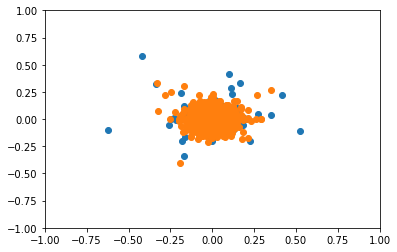

epoch: 3100, train cost_P 0.715695, train cost_Q: 0.715603, train cost: 0.845933, test cost: 0.865570, minimum test cost: 0.863535
means of test groups: tensor([[3.2025],
        [3.6357],
        [2.9383],
        [2.2640],
        [3.3670]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 2., 3.])


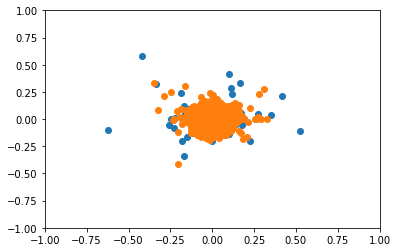

epoch: 3200, train cost_P 0.710236, train cost_Q: 0.710141, train cost: 0.842699, test cost: 0.863095, minimum test cost: 0.861071
means of test groups: tensor([[4.2320],
        [3.7697],
        [3.5346],
        [2.7992],
        [3.9471]], device='cuda:0')
ratings of test groups: tensor([5., 4., 3., 3., 4.])


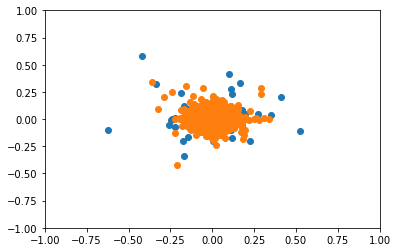

epoch: 3300, train cost_P 0.705138, train cost_Q: 0.705048, train cost: 0.839671, test cost: 0.860890, minimum test cost: 0.858751
means of test groups: tensor([[2.0246],
        [3.0396],
        [3.4063],
        [3.2014],
        [4.0816]], device='cuda:0')
ratings of test groups: tensor([2., 2., 4., 3., 4.])


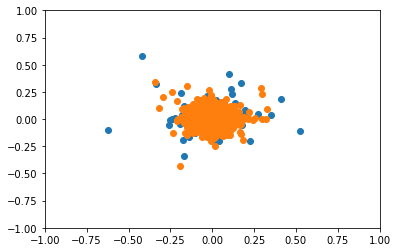

epoch: 3400, train cost_P 0.699915, train cost_Q: 0.699823, train cost: 0.836554, test cost: 0.858648, minimum test cost: 0.856502
means of test groups: tensor([[3.9670],
        [2.9583],
        [3.2566],
        [2.8806],
        [3.5054]], device='cuda:0')
ratings of test groups: tensor([5., 2., 3., 2., 4.])


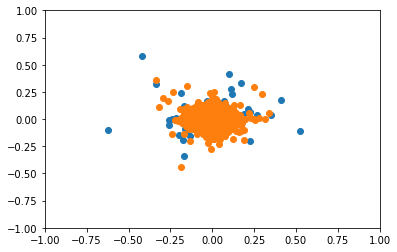

epoch: 3500, train cost_P 0.695004, train cost_Q: 0.694911, train cost: 0.833613, test cost: 0.856559, minimum test cost: 0.854366
means of test groups: tensor([[3.0636],
        [4.3048],
        [2.8842],
        [2.9218],
        [3.3057]], device='cuda:0')
ratings of test groups: tensor([3., 5., 3., 2., 5.])


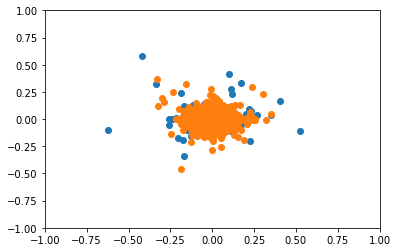

epoch: 3600, train cost_P 0.690157, train cost_Q: 0.690065, train cost: 0.830701, test cost: 0.854528, minimum test cost: 0.852320
means of test groups: tensor([[3.3153],
        [3.1832],
        [1.7194],
        [3.5423],
        [3.9145]], device='cuda:0')
ratings of test groups: tensor([4., 3., 2., 5., 5.])


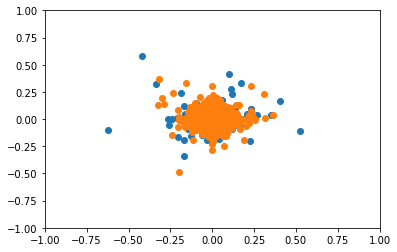

epoch: 3700, train cost_P 0.685452, train cost_Q: 0.685344, train cost: 0.827855, test cost: 0.852586, minimum test cost: 0.850361
means of test groups: tensor([[3.0181],
        [3.5431],
        [3.7256],
        [3.4318],
        [2.8224]], device='cuda:0')
ratings of test groups: tensor([3., 3., 4., 1., 3.])


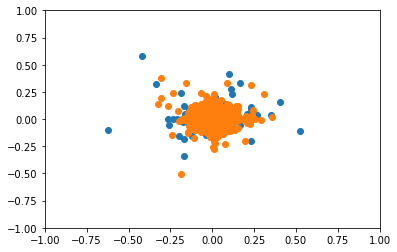

epoch: 3800, train cost_P 0.680774, train cost_Q: 0.680660, train cost: 0.825021, test cost: 0.850714, minimum test cost: 0.848462
means of test groups: tensor([[3.4175],
        [2.9186],
        [3.5399],
        [1.7726],
        [2.8404]], device='cuda:0')
ratings of test groups: tensor([1., 3., 4., 1., 3.])


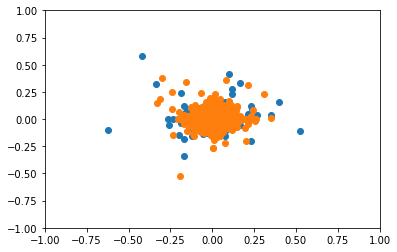

epoch: 3900, train cost_P 0.676317, train cost_Q: 0.676187, train cost: 0.822306, test cost: 0.848937, minimum test cost: 0.846680
means of test groups: tensor([[4.0323],
        [2.9793],
        [3.5735],
        [3.2017],
        [4.0977]], device='cuda:0')
ratings of test groups: tensor([1., 3., 3., 4., 5.])


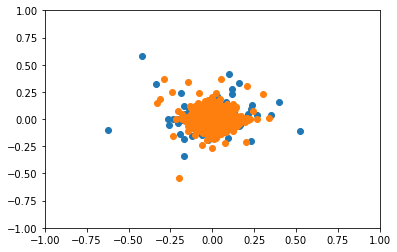

epoch: 4000, train cost_P 0.671998, train cost_Q: 0.671862, train cost: 0.819672, test cost: 0.847284, minimum test cost: 0.844948
means of test groups: tensor([[3.1465],
        [1.3425],
        [2.1005],
        [4.0561],
        [2.6538]], device='cuda:0')
ratings of test groups: tensor([0., 5., 2., 3., 4.])


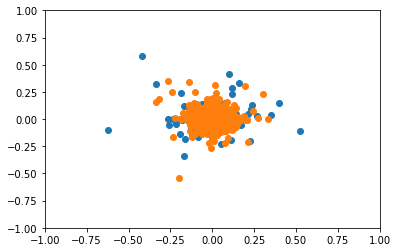

epoch: 4100, train cost_P 0.667688, train cost_Q: 0.667533, train cost: 0.817027, test cost: 0.845567, minimum test cost: 0.843277
means of test groups: tensor([[2.7487],
        [2.4432],
        [3.9162],
        [2.9130],
        [3.4424]], device='cuda:0')
ratings of test groups: tensor([2., 3., 4., 3., 3.])


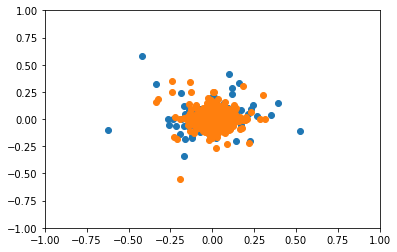

epoch: 4200, train cost_P 0.663498, train cost_Q: 0.663333, train cost: 0.814453, test cost: 0.843988, minimum test cost: 0.841631
means of test groups: tensor([[3.5205],
        [3.9549],
        [2.9659],
        [2.9170],
        [3.9139]], device='cuda:0')
ratings of test groups: tensor([4., 4., 2., 3., 4.])


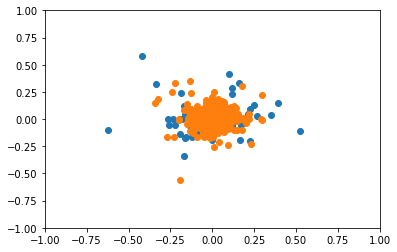

epoch: 4300, train cost_P 0.659276, train cost_Q: 0.659098, train cost: 0.811849, test cost: 0.842375, minimum test cost: 0.840003
means of test groups: tensor([[3.8195],
        [3.7226],
        [2.0898],
        [3.8608],
        [3.2899]], device='cuda:0')
ratings of test groups: tensor([4., 4., 2., 4., 3.])


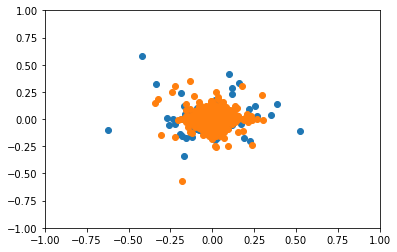

epoch: 4400, train cost_P 0.655069, train cost_Q: 0.654884, train cost: 0.809249, test cost: 0.840750, minimum test cost: 0.838420
means of test groups: tensor([[3.6368],
        [3.9830],
        [1.3144],
        [3.8962],
        [3.6807]], device='cuda:0')
ratings of test groups: tensor([3., 4., 1., 5., 4.])


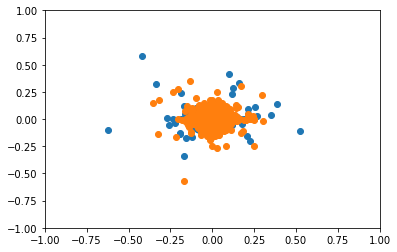

epoch: 4500, train cost_P 0.650929, train cost_Q: 0.650726, train cost: 0.806676, test cost: 0.839221, minimum test cost: 0.836856
means of test groups: tensor([[3.9302],
        [4.1158],
        [2.4965],
        [2.9524],
        [3.5944]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 3., 4.])


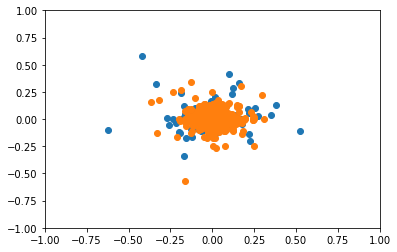

epoch: 4600, train cost_P 0.646766, train cost_Q: 0.646557, train cost: 0.804088, test cost: 0.837695, minimum test cost: 0.835316
means of test groups: tensor([[2.7420],
        [3.5345],
        [3.1130],
        [2.0308],
        [3.9933]], device='cuda:0')
ratings of test groups: tensor([1., 3., 3., 2., 5.])


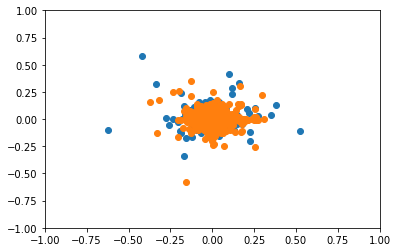

epoch: 4700, train cost_P 0.642688, train cost_Q: 0.642475, train cost: 0.801546, test cost: 0.836196, minimum test cost: 0.833837
means of test groups: tensor([[2.9547],
        [2.3151],
        [4.1107],
        [4.0044],
        [3.6082]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 5., 3.])


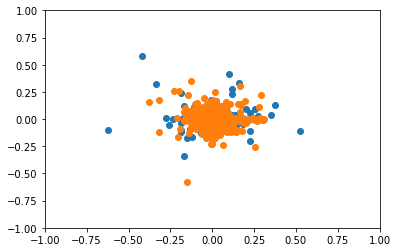

epoch: 4800, train cost_P 0.638669, train cost_Q: 0.638444, train cost: 0.799027, test cost: 0.834836, minimum test cost: 0.832430
means of test groups: tensor([[3.7600],
        [2.4278],
        [4.2581],
        [3.3760],
        [4.2961]], device='cuda:0')
ratings of test groups: tensor([4., 1., 5., 3., 5.])


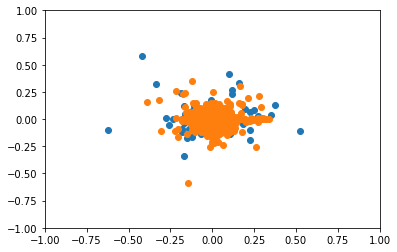

epoch: 4900, train cost_P 0.634681, train cost_Q: 0.634465, train cost: 0.796533, test cost: 0.833375, minimum test cost: 0.831083
means of test groups: tensor([[2.6462],
        [2.5135],
        [3.7472],
        [4.6821],
        [4.2613]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 5., 4.])


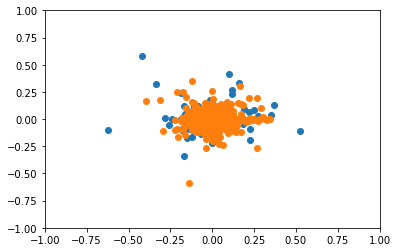

epoch: 5000, train cost_P 0.630970, train cost_Q: 0.630737, train cost: 0.794189, test cost: 0.832226, minimum test cost: 0.829869
means of test groups: tensor([[2.3232],
        [3.2327],
        [2.7878],
        [1.0459],
        [4.1553]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 1., 5.])


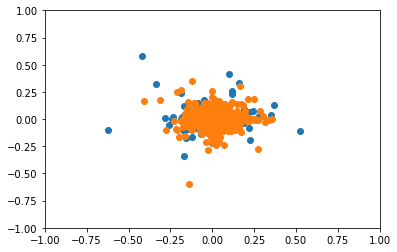

epoch: 5100, train cost_P 0.627230, train cost_Q: 0.627014, train cost: 0.791842, test cost: 0.830910, minimum test cost: 0.828657
means of test groups: tensor([[2.7795],
        [2.3426],
        [3.3826],
        [3.8841],
        [4.1824]], device='cuda:0')
ratings of test groups: tensor([1., 2., 4., 4., 5.])


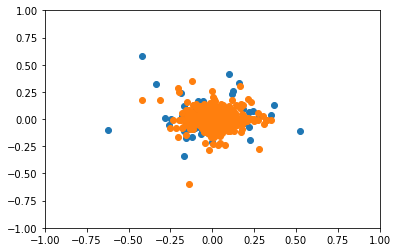

epoch: 5200, train cost_P 0.623749, train cost_Q: 0.623523, train cost: 0.789635, test cost: 0.829920, minimum test cost: 0.827571
means of test groups: tensor([[3.9802],
        [3.2303],
        [3.4600],
        [1.9583],
        [3.2028]], device='cuda:0')
ratings of test groups: tensor([5., 4., 1., 3., 3.])


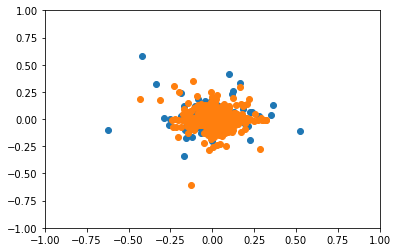

epoch: 5300, train cost_P 0.620272, train cost_Q: 0.620054, train cost: 0.787435, test cost: 0.828774, minimum test cost: 0.826518
means of test groups: tensor([[3.1391],
        [3.3875],
        [4.1858],
        [3.5747],
        [3.5012]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 3., 5.])


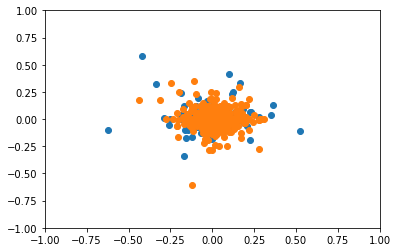

epoch: 5400, train cost_P 0.616951, train cost_Q: 0.616721, train cost: 0.785316, test cost: 0.827893, minimum test cost: 0.825524
means of test groups: tensor([[3.5835],
        [3.6544],
        [3.5005],
        [3.8152],
        [3.8512]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 4., 4.])


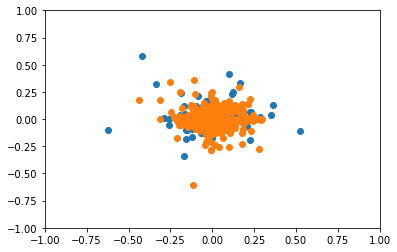

epoch: 5500, train cost_P 0.613622, train cost_Q: 0.613403, train cost: 0.783200, test cost: 0.826854, minimum test cost: 0.824570
means of test groups: tensor([[3.5978],
        [3.2293],
        [3.7134],
        [3.1193],
        [2.1951]], device='cuda:0')
ratings of test groups: tensor([3., 3., 5., 5., 3.])


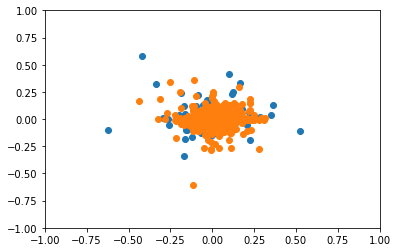

epoch: 5600, train cost_P 0.610418, train cost_Q: 0.610194, train cost: 0.781149, test cost: 0.826011, minimum test cost: 0.823656
means of test groups: tensor([[3.5510],
        [3.5284],
        [2.1176],
        [2.4511],
        [2.6550]], device='cuda:0')
ratings of test groups: tensor([3., 4., 2., 3., 4.])


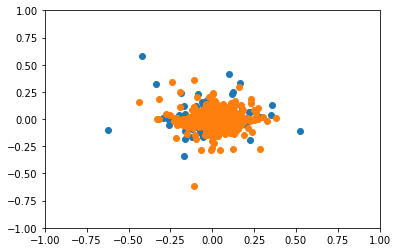

epoch: 5700, train cost_P 0.607323, train cost_Q: 0.607094, train cost: 0.779162, test cost: 0.825195, minimum test cost: 0.822811
means of test groups: tensor([[3.2375],
        [2.6655],
        [4.3517],
        [3.4598],
        [2.9547]], device='cuda:0')
ratings of test groups: tensor([3., 3., 4., 3., 4.])


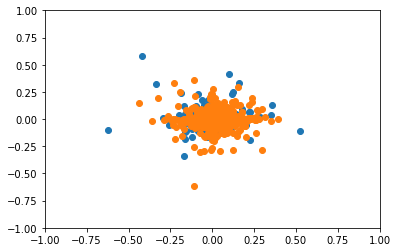

epoch: 5800, train cost_P 0.604198, train cost_Q: 0.603979, train cost: 0.777161, test cost: 0.824298, minimum test cost: 0.821991
means of test groups: tensor([[4.0057],
        [3.5155],
        [3.9750],
        [2.2791],
        [3.7074]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 1., 4.])


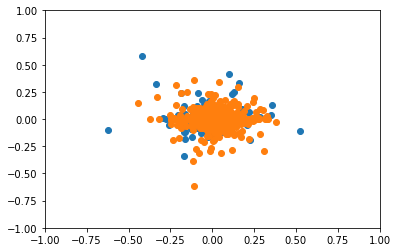

epoch: 5900, train cost_P 0.601231, train cost_Q: 0.601005, train cost: 0.775245, test cost: 0.823587, minimum test cost: 0.821210
means of test groups: tensor([[2.9424],
        [3.7959],
        [1.7350],
        [1.8759],
        [2.9415]], device='cuda:0')
ratings of test groups: tensor([3., 5., 1., 2., 2.])


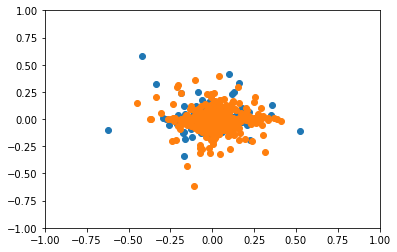

epoch: 6000, train cost_P 0.598259, train cost_Q: 0.598041, train cost: 0.773331, test cost: 0.822785, minimum test cost: 0.820481
means of test groups: tensor([[3.7936],
        [3.5327],
        [2.6374],
        [3.0356],
        [1.5979]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 2., 1.])


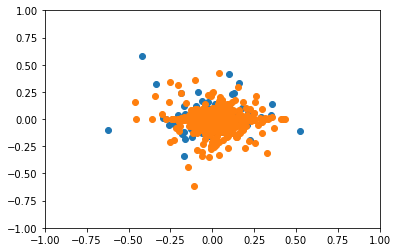

epoch: 6100, train cost_P 0.595340, train cost_Q: 0.595119, train cost: 0.771439, test cost: 0.822077, minimum test cost: 0.819751
means of test groups: tensor([[3.3467],
        [3.3613],
        [4.0883],
        [2.5132],
        [4.2625]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 4., 5.])


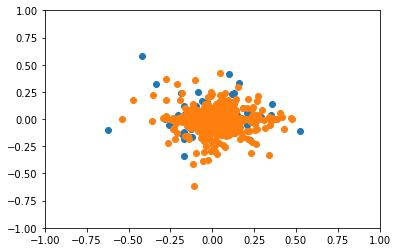

epoch: 6200, train cost_P 0.592439, train cost_Q: 0.592223, train cost: 0.769560, test cost: 0.821363, minimum test cost: 0.819075
means of test groups: tensor([[2.5079],
        [3.8728],
        [3.2990],
        [3.0919],
        [3.8937]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 3., 3.])


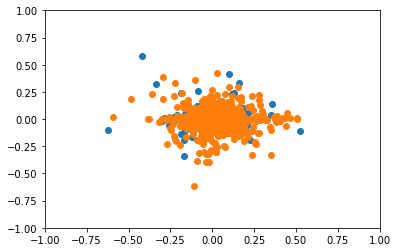

epoch: 6300, train cost_P 0.589660, train cost_Q: 0.589440, train cost: 0.767750, test cost: 0.820779, minimum test cost: 0.818456
means of test groups: tensor([[3.7129],
        [4.1615],
        [3.3221],
        [2.2207],
        [4.0604]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 3., 4.])


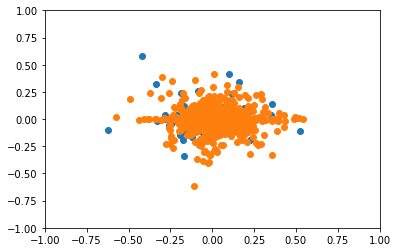

epoch: 6400, train cost_P 0.586869, train cost_Q: 0.586659, train cost: 0.765936, test cost: 0.820148, minimum test cost: 0.817867
means of test groups: tensor([[4.1038],
        [1.1840],
        [3.0496],
        [2.0307],
        [3.1573]], device='cuda:0')
ratings of test groups: tensor([4., 0., 4., 2., 3.])


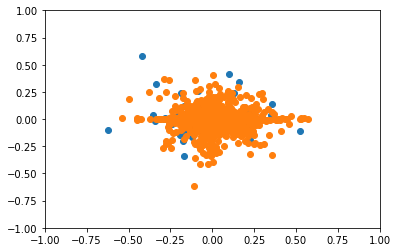

epoch: 6500, train cost_P 0.584216, train cost_Q: 0.584001, train cost: 0.764200, test cost: 0.819679, minimum test cost: 0.817345
means of test groups: tensor([[3.2757],
        [4.9518],
        [2.4956],
        [3.4149],
        [4.1812]], device='cuda:0')
ratings of test groups: tensor([4., 5., 1., 4., 4.])


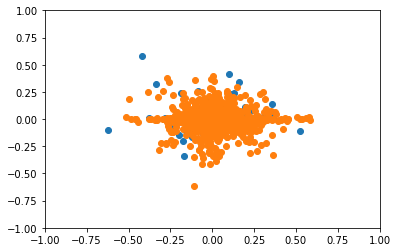

epoch: 6600, train cost_P 0.581600, train cost_Q: 0.581393, train cost: 0.762491, test cost: 0.819141, minimum test cost: 0.816864
means of test groups: tensor([[3.8522],
        [3.6301],
        [2.1068],
        [3.3888],
        [3.2993]], device='cuda:0')
ratings of test groups: tensor([5., 2., 2., 4., 4.])


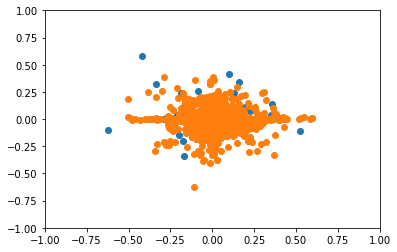

epoch: 6700, train cost_P 0.579021, train cost_Q: 0.578808, train cost: 0.760794, test cost: 0.818752, minimum test cost: 0.816405
means of test groups: tensor([[3.2624],
        [3.4982],
        [2.6829],
        [3.5731],
        [2.5627]], device='cuda:0')
ratings of test groups: tensor([4., 3., 5., 2., 3.])


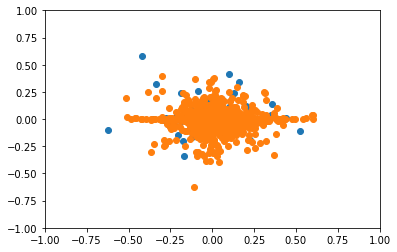

epoch: 6800, train cost_P 0.576476, train cost_Q: 0.576259, train cost: 0.759118, test cost: 0.818315, minimum test cost: 0.815944
means of test groups: tensor([[2.9344],
        [3.4168],
        [3.1347],
        [4.1521],
        [2.9508]], device='cuda:0')
ratings of test groups: tensor([2., 3., 2., 4., 4.])


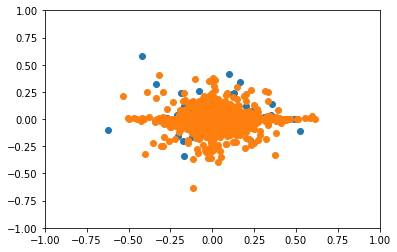

epoch: 6900, train cost_P 0.573813, train cost_Q: 0.573600, train cost: 0.757364, test cost: 0.817819, minimum test cost: 0.815441
means of test groups: tensor([[3.0194],
        [3.2266],
        [3.3408],
        [2.1542],
        [3.4449]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 3., 3.])


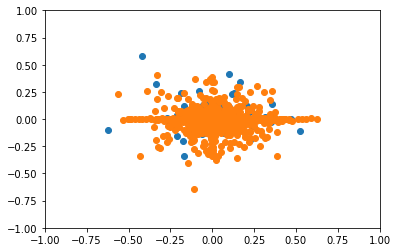

epoch: 7000, train cost_P 0.571126, train cost_Q: 0.570917, train cost: 0.755591, test cost: 0.817286, minimum test cost: 0.814943
means of test groups: tensor([[3.9251],
        [4.6523],
        [3.5649],
        [1.8702],
        [2.4759]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 4., 1.])


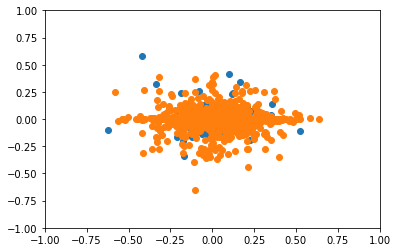

epoch: 7100, train cost_P 0.568412, train cost_Q: 0.568205, train cost: 0.753794, test cost: 0.816753, minimum test cost: 0.814437
means of test groups: tensor([[3.3982],
        [2.3275],
        [1.8850],
        [3.0626],
        [3.6785]], device='cuda:0')
ratings of test groups: tensor([3., 2., 0., 3., 4.])


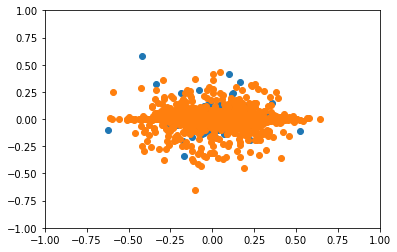

epoch: 7200, train cost_P 0.565735, train cost_Q: 0.565530, train cost: 0.752017, test cost: 0.816251, minimum test cost: 0.813944
means of test groups: tensor([[3.8186],
        [3.3413],
        [3.6024],
        [3.5485],
        [3.9639]], device='cuda:0')
ratings of test groups: tensor([5., 5., 3., 4., 3.])


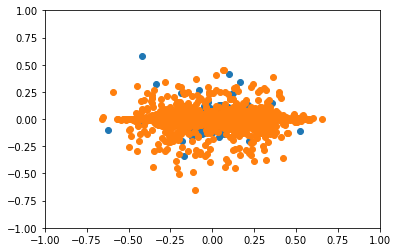

epoch: 7300, train cost_P 0.563097, train cost_Q: 0.562897, train cost: 0.750265, test cost: 0.815785, minimum test cost: 0.813489
means of test groups: tensor([[3.7162],
        [2.8420],
        [3.4439],
        [4.3281],
        [3.9624]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 5., 5.])


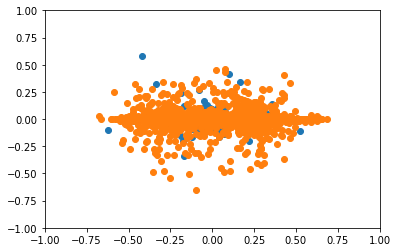

epoch: 7400, train cost_P 0.560500, train cost_Q: 0.560305, train cost: 0.748535, test cost: 0.815394, minimum test cost: 0.813110
means of test groups: tensor([[3.0318],
        [2.6489],
        [2.8398],
        [1.0595],
        [3.7181]], device='cuda:0')
ratings of test groups: tensor([4., 2., 3., 2., 3.])


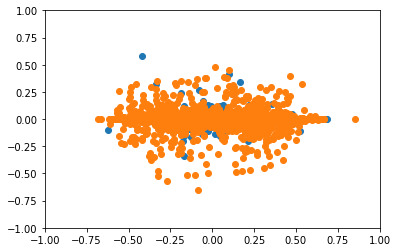

epoch: 7500, train cost_P 0.558016, train cost_Q: 0.557822, train cost: 0.746875, test cost: 0.815139, minimum test cost: 0.812849
means of test groups: tensor([[3.9461],
        [3.4479],
        [3.3828],
        [3.4667],
        [4.2580]], device='cuda:0')
ratings of test groups: tensor([5., 4., 3., 3., 5.])


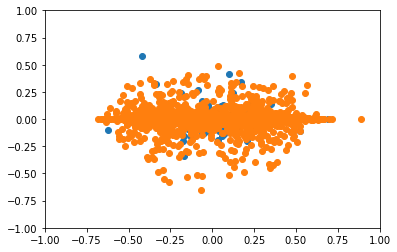

epoch: 7600, train cost_P 0.555640, train cost_Q: 0.555446, train cost: 0.745282, test cost: 0.814989, minimum test cost: 0.812674
means of test groups: tensor([[4.1692],
        [3.5842],
        [3.7372],
        [3.5479],
        [3.0388]], device='cuda:0')
ratings of test groups: tensor([4., 5., 5., 3., 2.])


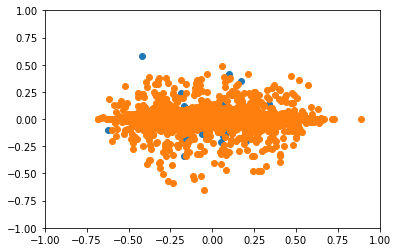

epoch: 7700, train cost_P 0.553340, train cost_Q: 0.553140, train cost: 0.743734, test cost: 0.814903, minimum test cost: 0.812534
means of test groups: tensor([[1.0002],
        [2.5748],
        [3.9654],
        [3.1538],
        [1.5192]], device='cuda:0')
ratings of test groups: tensor([1., 2., 4., 4., 1.])


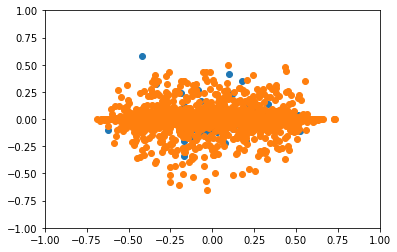

epoch: 7800, train cost_P 0.551037, train cost_Q: 0.550828, train cost: 0.742178, test cost: 0.814780, minimum test cost: 0.812327
means of test groups: tensor([[3.9770],
        [3.2356],
        [3.9787],
        [4.2602],
        [3.0701]], device='cuda:0')
ratings of test groups: tensor([4., 3., 5., 5., 4.])


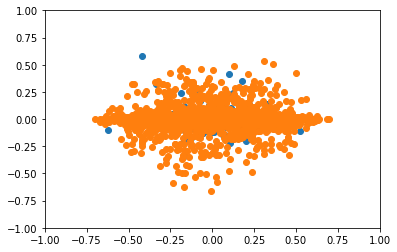

epoch: 7900, train cost_P 0.548598, train cost_Q: 0.548392, train cost: 0.740535, test cost: 0.814416, minimum test cost: 0.812006
means of test groups: tensor([[3.6606],
        [2.1384],
        [2.4247],
        [3.9097],
        [2.1119]], device='cuda:0')
ratings of test groups: tensor([2., 1., 4., 4., 2.])


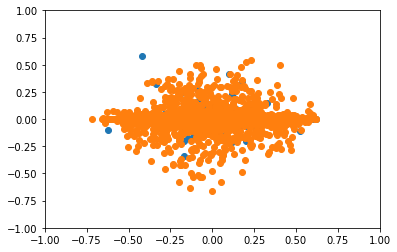

epoch: 8000, train cost_P 0.546047, train cost_Q: 0.545847, train cost: 0.738815, test cost: 0.814020, minimum test cost: 0.811651
means of test groups: tensor([[3.3777],
        [2.9558],
        [3.6587],
        [3.9229],
        [3.2981]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 3., 3.])


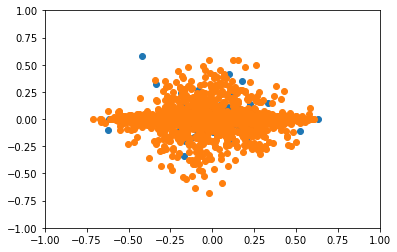

epoch: 8100, train cost_P 0.543541, train cost_Q: 0.543338, train cost: 0.737114, test cost: 0.813717, minimum test cost: 0.811298
means of test groups: tensor([[3.9357],
        [2.5506],
        [3.0373],
        [3.1031],
        [2.9476]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 4., 1.])


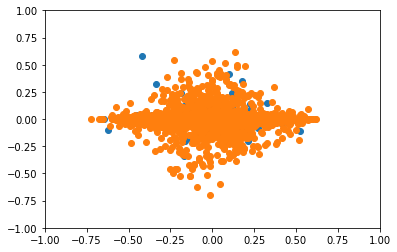

epoch: 8200, train cost_P 0.541002, train cost_Q: 0.540820, train cost: 0.735405, test cost: 0.813308, minimum test cost: 0.811045
means of test groups: tensor([[2.9586],
        [3.8469],
        [4.3383],
        [3.3750],
        [3.8959]], device='cuda:0')
ratings of test groups: tensor([4., 5., 4., 4., 4.])


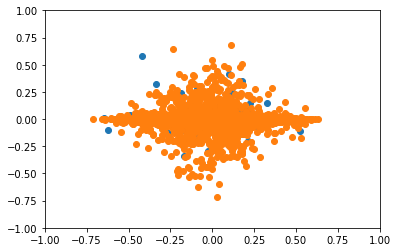

epoch: 8300, train cost_P 0.538599, train cost_Q: 0.538421, train cost: 0.733772, test cost: 0.813194, minimum test cost: 0.810930
means of test groups: tensor([[3.5144],
        [2.7024],
        [2.7742],
        [2.6136],
        [2.6689]], device='cuda:0')
ratings of test groups: tensor([4., 3., 2., 3., 0.])


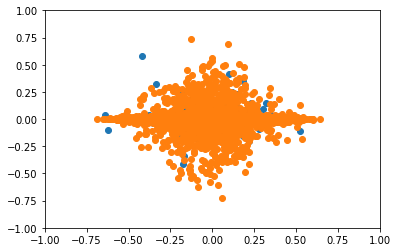

epoch: 8400, train cost_P 0.536349, train cost_Q: 0.536167, train cost: 0.732234, test cost: 0.813240, minimum test cost: 0.810915
means of test groups: tensor([[2.4854],
        [3.9418],
        [4.7567],
        [4.4058],
        [2.8077]], device='cuda:0')
ratings of test groups: tensor([2., 4., 5., 4., 3.])


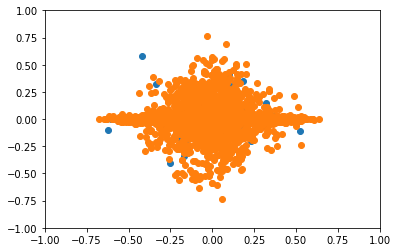

epoch: 8500, train cost_P 0.534187, train cost_Q: 0.534008, train cost: 0.730758, test cost: 0.813266, minimum test cost: 0.810915
means of test groups: tensor([[3.7264],
        [2.5706],
        [3.9313],
        [4.2673],
        [3.3906]], device='cuda:0')
ratings of test groups: tensor([3., 3., 5., 4., 4.])


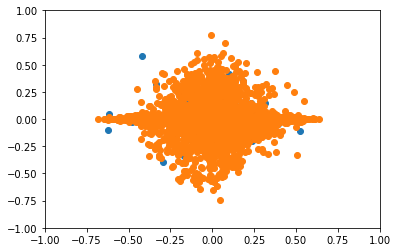

epoch: 8600, train cost_P 0.532113, train cost_Q: 0.531932, train cost: 0.729337, test cost: 0.813377, minimum test cost: 0.810915
means of test groups: tensor([[5.0196],
        [4.0174],
        [3.5042],
        [4.2172],
        [2.9944]], device='cuda:0')
ratings of test groups: tensor([5., 5., 3., 3., 3.])


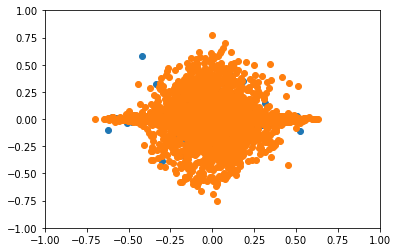

epoch: 8700, train cost_P 0.530126, train cost_Q: 0.529939, train cost: 0.727969, test cost: 0.813528, minimum test cost: 0.810915
means of test groups: tensor([[3.2610],
        [3.2255],
        [2.6003],
        [3.8490],
        [4.2913]], device='cuda:0')
ratings of test groups: tensor([3., 5., 4., 4., 4.])


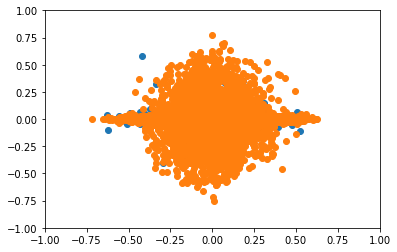

epoch: 8800, train cost_P 0.528130, train cost_Q: 0.527936, train cost: 0.726592, test cost: 0.813600, minimum test cost: 0.810915
means of test groups: tensor([[4.2223],
        [3.9488],
        [3.4070],
        [1.8762],
        [3.1333]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 2., 3.])


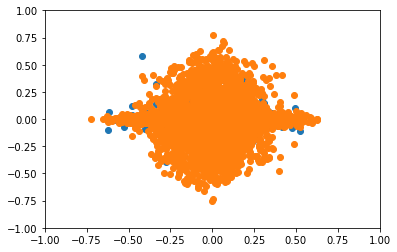

epoch: 8900, train cost_P 0.526045, train cost_Q: 0.525856, train cost: 0.725159, test cost: 0.813563, minimum test cost: 0.810915
means of test groups: tensor([[3.5423],
        [3.3567],
        [3.6825],
        [3.1461],
        [4.0860]], device='cuda:0')
ratings of test groups: tensor([3., 3., 1., 3., 4.])


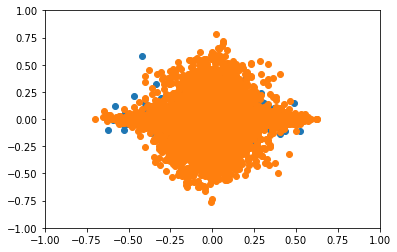

epoch: 9000, train cost_P 0.523963, train cost_Q: 0.523759, train cost: 0.723712, test cost: 0.813683, minimum test cost: 0.810915
means of test groups: tensor([[3.9098],
        [2.2553],
        [3.7005],
        [3.8329],
        [3.9172]], device='cuda:0')
ratings of test groups: tensor([4., 2., 5., 4., 3.])


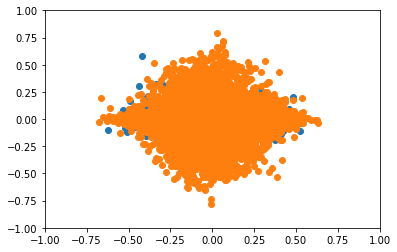

epoch: 9100, train cost_P 0.521739, train cost_Q: 0.521535, train cost: 0.722174, test cost: 0.813556, minimum test cost: 0.810915
means of test groups: tensor([[2.4712],
        [3.4697],
        [3.4230],
        [1.9912],
        [3.3122]], device='cuda:0')
ratings of test groups: tensor([4., 4., 5., 2., 3.])


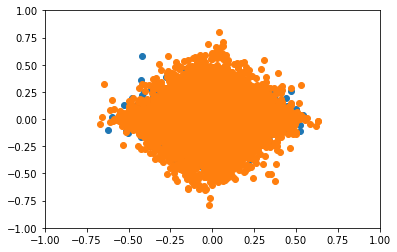

epoch: 9200, train cost_P 0.519379, train cost_Q: 0.519203, train cost: 0.720558, test cost: 0.813310, minimum test cost: 0.810915
means of test groups: tensor([[3.2612],
        [2.7653],
        [1.1415],
        [2.6470],
        [1.8177]], device='cuda:0')
ratings of test groups: tensor([3., 3., 1., 1., 4.])


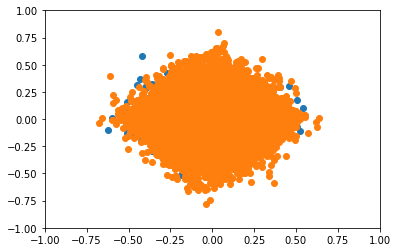

epoch: 9300, train cost_P 0.517117, train cost_Q: 0.516941, train cost: 0.718986, test cost: 0.813363, minimum test cost: 0.810915
means of test groups: tensor([[2.8853],
        [3.0730],
        [3.0726],
        [3.8801],
        [2.0560]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 4., 3.])


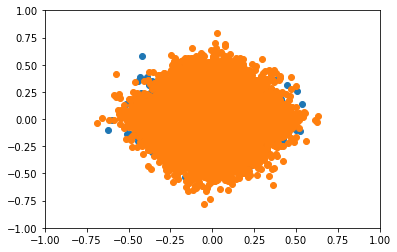

epoch: 9400, train cost_P 0.514932, train cost_Q: 0.514758, train cost: 0.717466, test cost: 0.813443, minimum test cost: 0.810915
means of test groups: tensor([[3.4894],
        [3.7306],
        [2.8911],
        [3.2154],
        [3.9774]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 3., 5.])


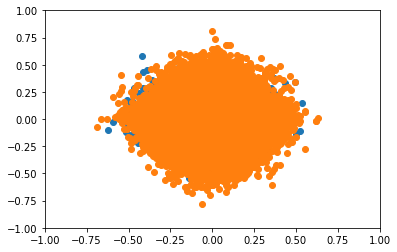

epoch: 9500, train cost_P 0.512830, train cost_Q: 0.512663, train cost: 0.716005, test cost: 0.813547, minimum test cost: 0.810915
means of test groups: tensor([[3.4949],
        [3.9508],
        [3.0832],
        [2.6022],
        [3.1762]], device='cuda:0')
ratings of test groups: tensor([3., 4., 2., 3., 4.])


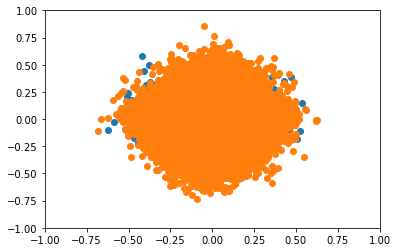

epoch: 9600, train cost_P 0.510857, train cost_Q: 0.510691, train cost: 0.714626, test cost: 0.813798, minimum test cost: 0.810915
means of test groups: tensor([[2.6186],
        [3.1808],
        [3.4491],
        [4.1195],
        [3.2581]], device='cuda:0')
ratings of test groups: tensor([3., 3., 4., 5., 3.])


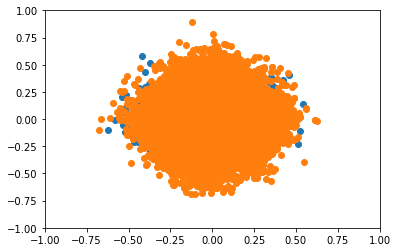

epoch: 9700, train cost_P 0.509015, train cost_Q: 0.508848, train cost: 0.713336, test cost: 0.814129, minimum test cost: 0.810915
means of test groups: tensor([[3.2174],
        [3.4892],
        [1.8049],
        [3.8660],
        [3.9994]], device='cuda:0')
ratings of test groups: tensor([3., 4., 2., 4., 4.])


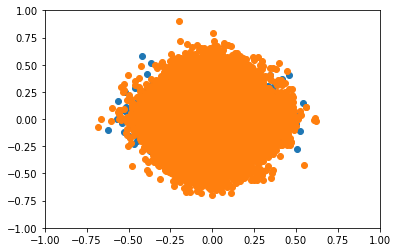

epoch: 9800, train cost_P 0.507282, train cost_Q: 0.507118, train cost: 0.712122, test cost: 0.814498, minimum test cost: 0.810915
means of test groups: tensor([[4.2503],
        [2.9974],
        [3.4537],
        [4.1512],
        [2.5371]], device='cuda:0')
ratings of test groups: tensor([4., 3., 3., 5., 3.])


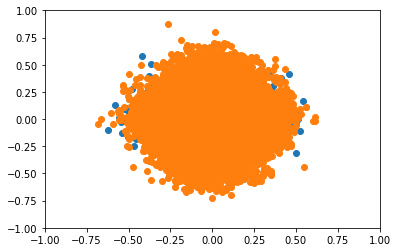

epoch: 9900, train cost_P 0.505658, train cost_Q: 0.505494, train cost: 0.710981, test cost: 0.814932, minimum test cost: 0.810915
means of test groups: tensor([[3.5162],
        [2.4393],
        [4.2876],
        [3.7895],
        [3.1676]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 5., 2.])


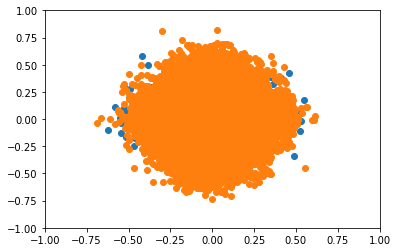

epoch: 10000, train cost_P 0.504127, train cost_Q: 0.503963, train cost: 0.709904, test cost: 0.815387, minimum test cost: 0.810915
means of test groups: tensor([[1.9226],
        [3.8156],
        [4.2024],
        [3.8606],
        [3.4796]], device='cuda:0')
ratings of test groups: tensor([2., 5., 3., 5., 4.])


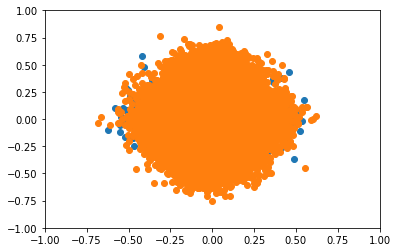

epoch: 10100, train cost_P 0.502675, train cost_Q: 0.502514, train cost: 0.708882, test cost: 0.815850, minimum test cost: 0.810915
means of test groups: tensor([[2.5462],
        [2.3075],
        [2.7820],
        [3.6568],
        [3.5611]], device='cuda:0')
ratings of test groups: tensor([3., 2., 3., 5., 3.])


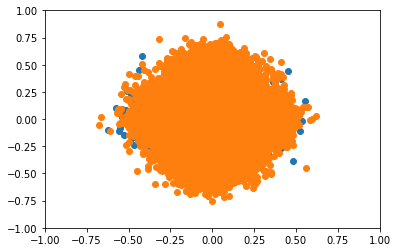

epoch: 10200, train cost_P 0.501295, train cost_Q: 0.501135, train cost: 0.707909, test cost: 0.816337, minimum test cost: 0.810915
means of test groups: tensor([[4.0034],
        [3.5123],
        [3.7265],
        [3.2764],
        [4.1901]], device='cuda:0')
ratings of test groups: tensor([5., 3., 4., 1., 4.])


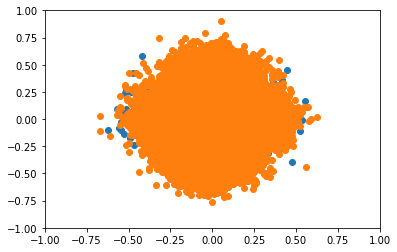

epoch: 10300, train cost_P 0.499975, train cost_Q: 0.499816, train cost: 0.706977, test cost: 0.816828, minimum test cost: 0.810915
means of test groups: tensor([[2.9505],
        [3.4656],
        [3.1880],
        [3.3250],
        [4.2947]], device='cuda:0')
ratings of test groups: tensor([3., 4., 3., 4., 4.])


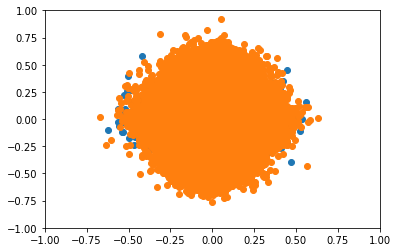

epoch: 10400, train cost_P 0.498710, train cost_Q: 0.498554, train cost: 0.706084, test cost: 0.817321, minimum test cost: 0.810915
means of test groups: tensor([[3.3333],
        [3.3981],
        [4.3803],
        [3.6942],
        [3.3945]], device='cuda:0')
ratings of test groups: tensor([4., 5., 5., 3., 2.])


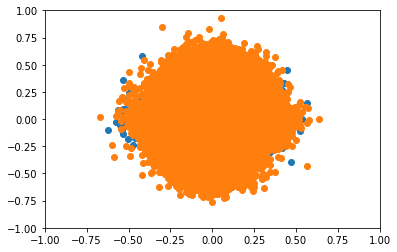

epoch: 10500, train cost_P 0.497507, train cost_Q: 0.497352, train cost: 0.705232, test cost: 0.817850, minimum test cost: 0.810915
means of test groups: tensor([[4.0410],
        [3.2133],
        [2.7507],
        [2.8974],
        [3.0638]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 3., 3.])


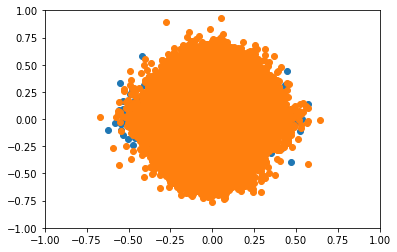

epoch: 10600, train cost_P 0.496363, train cost_Q: 0.496209, train cost: 0.704421, test cost: 0.818403, minimum test cost: 0.810915
means of test groups: tensor([[5.0050],
        [4.3668],
        [3.8607],
        [3.5670],
        [3.1595]], device='cuda:0')
ratings of test groups: tensor([4., 2., 4., 4., 3.])


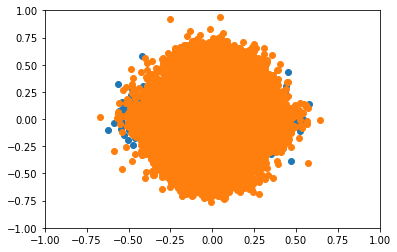

epoch: 10700, train cost_P 0.495273, train cost_Q: 0.495119, train cost: 0.703647, test cost: 0.818961, minimum test cost: 0.810915
means of test groups: tensor([[3.2613],
        [3.6282],
        [4.0685],
        [4.0467],
        [4.2125]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 3., 4.])


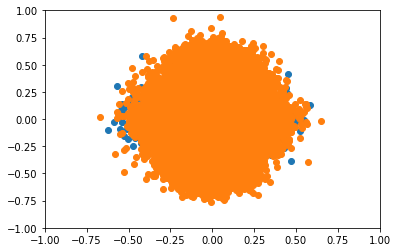

epoch: 10800, train cost_P 0.494232, train cost_Q: 0.494080, train cost: 0.702908, test cost: 0.819534, minimum test cost: 0.810915
means of test groups: tensor([[3.0689],
        [1.5335],
        [2.3585],
        [3.7064],
        [3.3232]], device='cuda:0')
ratings of test groups: tensor([2., 1., 1., 2., 3.])


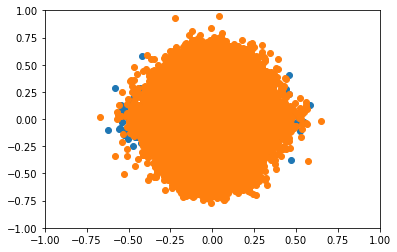

epoch: 10900, train cost_P 0.493242, train cost_Q: 0.493090, train cost: 0.702204, test cost: 0.820123, minimum test cost: 0.810915
means of test groups: tensor([[3.6906],
        [3.6680],
        [3.1990],
        [2.7779],
        [3.3796]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 3., 4.])


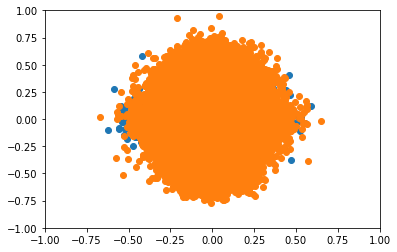

epoch: 11000, train cost_P 0.492296, train cost_Q: 0.492145, train cost: 0.701531, test cost: 0.820714, minimum test cost: 0.810915
means of test groups: tensor([[3.6709],
        [3.9383],
        [3.6334],
        [3.4279],
        [4.6886]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 4., 4.])


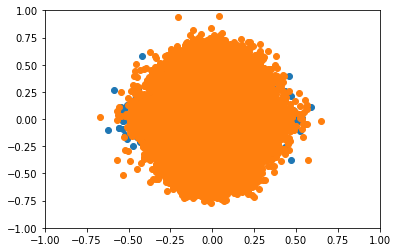

epoch: 11100, train cost_P 0.491391, train cost_Q: 0.491243, train cost: 0.700887, test cost: 0.821308, minimum test cost: 0.810915
means of test groups: tensor([[3.7766],
        [3.6072],
        [2.7489],
        [4.4928],
        [0.7947]], device='cuda:0')
ratings of test groups: tensor([5., 3., 4., 5., 1.])


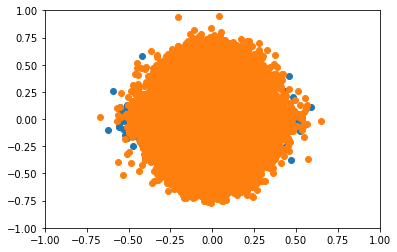

epoch: 11200, train cost_P 0.490528, train cost_Q: 0.490380, train cost: 0.700271, test cost: 0.821910, minimum test cost: 0.810915
means of test groups: tensor([[4.2203],
        [2.5577],
        [3.8868],
        [5.1976],
        [3.2377]], device='cuda:0')
ratings of test groups: tensor([5., 2., 3., 5., 4.])


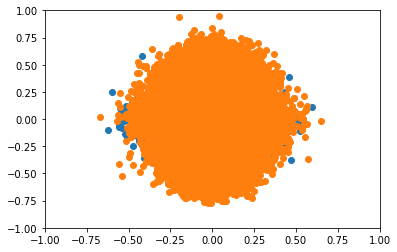

epoch: 11300, train cost_P 0.489701, train cost_Q: 0.489554, train cost: 0.699682, test cost: 0.822511, minimum test cost: 0.810915
means of test groups: tensor([[3.7573],
        [5.3178],
        [3.2544],
        [3.3342],
        [2.9281]], device='cuda:0')
ratings of test groups: tensor([5., 5., 3., 4., 3.])


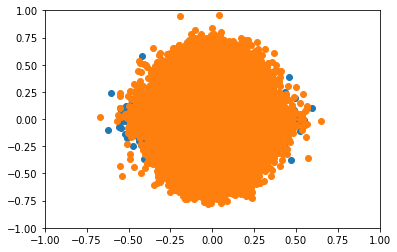

epoch: 11400, train cost_P 0.488909, train cost_Q: 0.488764, train cost: 0.699116, test cost: 0.823111, minimum test cost: 0.810915
means of test groups: tensor([[3.3604],
        [3.6332],
        [3.4551],
        [2.8375],
        [3.0590]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 3., 3.])


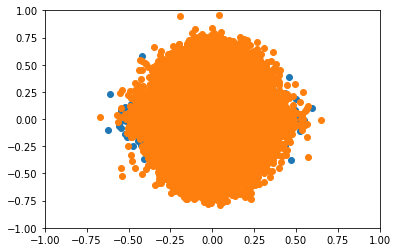

epoch: 11500, train cost_P 0.488151, train cost_Q: 0.488006, train cost: 0.698574, test cost: 0.823715, minimum test cost: 0.810915
means of test groups: tensor([[3.3532],
        [3.8594],
        [3.5020],
        [3.5032],
        [3.9897]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 3., 5.])


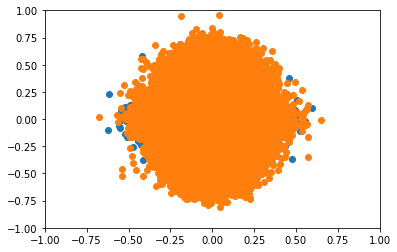

epoch: 11600, train cost_P 0.487424, train cost_Q: 0.487280, train cost: 0.698054, test cost: 0.824321, minimum test cost: 0.810915
means of test groups: tensor([[2.7517],
        [3.5167],
        [4.7583],
        [1.7532],
        [3.2830]], device='cuda:0')
ratings of test groups: tensor([3., 3., 5., 3., 3.])


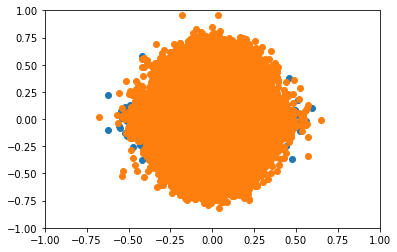

epoch: 11700, train cost_P 0.486726, train cost_Q: 0.486583, train cost: 0.697555, test cost: 0.824924, minimum test cost: 0.810915
means of test groups: tensor([[3.5214],
        [4.2450],
        [3.3763],
        [3.5282],
        [2.6409]], device='cuda:0')
ratings of test groups: tensor([4., 5., 5., 3., 2.])


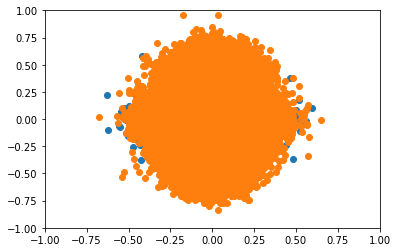

epoch: 11800, train cost_P 0.486055, train cost_Q: 0.485913, train cost: 0.697075, test cost: 0.825525, minimum test cost: 0.810915
means of test groups: tensor([[3.8992],
        [3.0383],
        [3.6695],
        [3.4677],
        [4.4314]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 3., 4.])


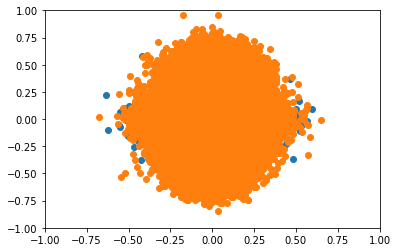

epoch: 11900, train cost_P 0.485411, train cost_Q: 0.485270, train cost: 0.696614, test cost: 0.826125, minimum test cost: 0.810915
means of test groups: tensor([[4.0727],
        [2.5079],
        [4.1537],
        [3.0802],
        [3.5657]], device='cuda:0')
ratings of test groups: tensor([4., 3., 5., 4., 1.])


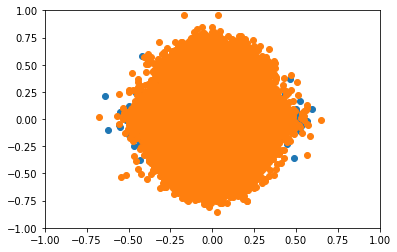

epoch: 12000, train cost_P 0.484792, train cost_Q: 0.484652, train cost: 0.696170, test cost: 0.826725, minimum test cost: 0.810915
means of test groups: tensor([[4.9444],
        [2.6408],
        [3.3184],
        [3.2524],
        [2.8459]], device='cuda:0')
ratings of test groups: tensor([5., 3., 3., 3., 3.])


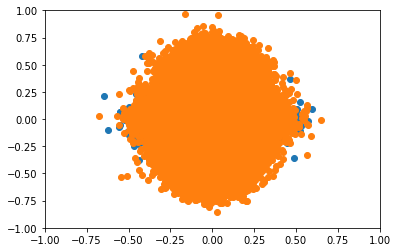

epoch: 12100, train cost_P 0.484197, train cost_Q: 0.484058, train cost: 0.695742, test cost: 0.827323, minimum test cost: 0.810915
means of test groups: tensor([[3.3169],
        [3.2029],
        [3.6202],
        [4.9756],
        [4.5571]], device='cuda:0')
ratings of test groups: tensor([3., 3., 4., 5., 4.])


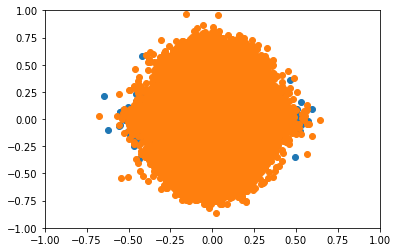

epoch: 12200, train cost_P 0.483621, train cost_Q: 0.483484, train cost: 0.695330, test cost: 0.827905, minimum test cost: 0.810915
means of test groups: tensor([[3.3421],
        [3.2299],
        [2.9917],
        [3.5800],
        [4.7634]], device='cuda:0')
ratings of test groups: tensor([5., 2., 3., 5., 4.])


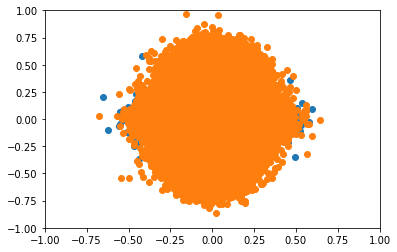

epoch: 12300, train cost_P 0.483077, train cost_Q: 0.482937, train cost: 0.694936, test cost: 0.828526, minimum test cost: 0.810915
means of test groups: tensor([[4.2949],
        [3.1040],
        [3.4786],
        [4.3488],
        [4.0390]], device='cuda:0')
ratings of test groups: tensor([5., 3., 3., 4., 4.])


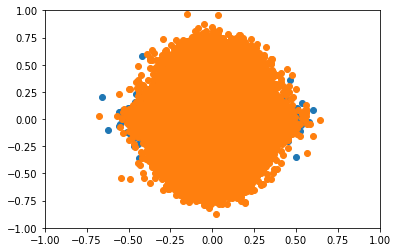

epoch: 12400, train cost_P 0.482530, train cost_Q: 0.482398, train cost: 0.694549, test cost: 0.829068, minimum test cost: 0.810915
means of test groups: tensor([[3.4796],
        [3.6729],
        [3.9073],
        [2.0742],
        [2.8768]], device='cuda:0')
ratings of test groups: tensor([4., 4., 3., 2., 4.])


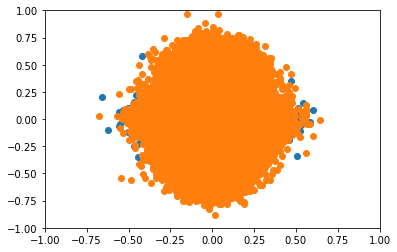

epoch: 12500, train cost_P 0.482035, train cost_Q: 0.481894, train cost: 0.694186, test cost: 0.829734, minimum test cost: 0.810915
means of test groups: tensor([[2.1970],
        [4.2786],
        [4.5461],
        [3.6417],
        [2.0023]], device='cuda:0')
ratings of test groups: tensor([2., 4., 5., 4., 2.])


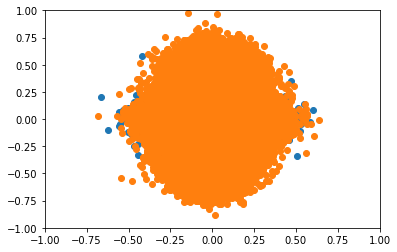

epoch: 12600, train cost_P 0.481523, train cost_Q: 0.481391, train cost: 0.693824, test cost: 0.830266, minimum test cost: 0.810915
means of test groups: tensor([[3.7635],
        [3.0236],
        [2.2905],
        [2.6936],
        [3.9849]], device='cuda:0')
ratings of test groups: tensor([5., 2., 2., 3., 2.])


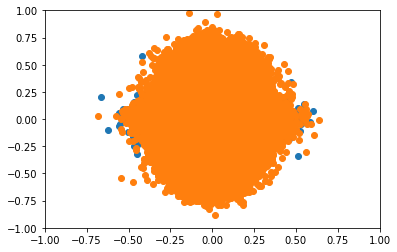

epoch: 12700, train cost_P 0.481056, train cost_Q: 0.480919, train cost: 0.693484, test cost: 0.830892, minimum test cost: 0.810915
means of test groups: tensor([[3.2937],
        [3.8585],
        [3.7002],
        [3.1733],
        [2.9306]], device='cuda:0')
ratings of test groups: tensor([4., 4., 2., 5., 3.])


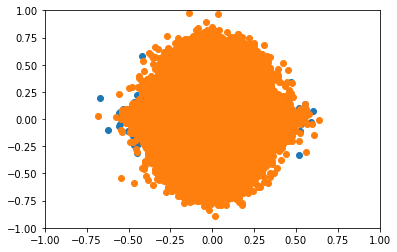

epoch: 12800, train cost_P 0.480584, train cost_Q: 0.480451, train cost: 0.693146, test cost: 0.831477, minimum test cost: 0.810915
means of test groups: tensor([[2.8502],
        [4.7409],
        [1.9096],
        [0.8799],
        [2.0658]], device='cuda:0')
ratings of test groups: tensor([3., 4., 2., 3., 1.])


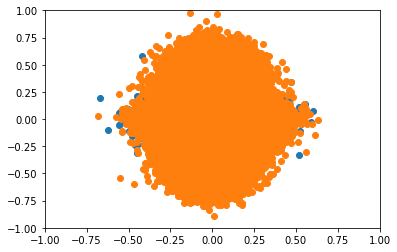

KeyboardInterrupt: 

In [21]:
# # mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
optimizer_Q = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
scheduler_P = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_P, T_0 = 10, eta_min = 0.001, last_epoch = -1)
scheduler_Q = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_Q, T_0 = 10, eta_min = 0.001, last_epoch = -1)


X = []
Y = []
Y_test = []
hypo_test = []
true_rating = []
idx_list = []
cost_list = []
cost_test_list = []


for epoch in range(20000):

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device).unsqueeze(1)
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  
                    
    cost_P = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))                                                                                                        
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward()
    optimizer_P.step()
    scheduler_P.step()
    
#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device).unsqueeze(1)
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  
                    
    cost_Q = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))

    optimizer_Q.zero_grad()
    cost_Q.backward()
    optimizer_Q.step()
    optimizer_Q.step()  
    
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
 #       hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1)) + (torch.abs(bi[items_test]) + torch.abs(bu[users_test])).to(device).unsqueeze(1)                
        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1))  

          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)

        Y_test.append(cost_test.item() ** 0.5)
        
        cost_list.append(cost)
        cost_test_list.append(cost_test)
        
    if epoch % 100 == 0:
        idx = np.random.choice(1000005, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost_Q: {:.6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item() , cost_Q.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        hypo_test.append(hypo_test_mean[idx])
        true_rating.append(ratings_test[idx])
        idx_list.append(idx)
        
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

In [ ]:
# rank 20 : 0.80014: both 
# rank 15 : 0.81329
# rank 10 : 0.8454
# rank 25 : 
# rank 30 : 

In [22]:
len(X), len(Y_test)

(12881, 12881)

In [23]:
len(hypo_test), len(true_rating)

(129, 129)

In [24]:
X2 = X[:11876]
Y_test2 = Y_test[:11876]
cost_list2 = cost_list[:11866]
cost_test_list2 = cost_list[:11876]

In [25]:
tr = []
tr_sort = []
for i in range(len(true_rating)):
    trc = true_rating[i].to(device)
    tr.append(trc)
for j in range(len(tr)):
    trs = tr[j].sort(descending = True)[0]
    tr_sort.append(trs)

In [26]:
ndcg_list = []
idcg_list = []
dcg_list = []
for r in tqdm(range(len(hypo_test))):
    for i in range(5):
        idcg = tr_sort[r][i] / np.log2(i+1 + 1)
        idcg_list.append(idcg)
        sum_idcg = sum(idcg_list)
    for j in range(5):
        dcg = hypo_test[r][j] / np.log2(j+1 + 1)
        dcg_list.append(dcg)
        sum_dcg = sum(dcg_list)
    
    ndcg = sum_dcg / sum_idcg
    ndcg_list.append(ndcg)

100%|██████████| 129/129 [00:02<00:00, 47.53it/s]


In [27]:
nd = []
ct = []
cl = []
for i in range(len(ndcg_list)):
    nds = ndcg_list[i].tolist()
    nd.append(nds)
for j in range(len(cost_test_list2)):
    cts = cost_test_list2[j].tolist()
    ct.append(cts)
for k in range(len(cost_list2)):
    cls = cost_list2[k].tolist()
    cl.append(cls)

In [28]:
nd2 = nd[:119]
epochs = [i for i in range(0, 119)]
y_epoch = [i for i in range(0, 11876)]

In [29]:
import csv

In [30]:
with open("10m_normsvd_Y_test2.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(y_epoch)
        writer.writerows([Y_test2])

In [31]:
with open("10m_normsvd_ndcg2.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(epochs)
        writer.writerows(nd2)


In [32]:
with open("10m_normsvd_cost_test_list2.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(y_epoch)
        writer.writerows([ct])

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:

# mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P] + list(layers_mean.parameters()), lr= 1e-3)
optimizer_Q = torch.optim.Adam([Q] + list(layers_mean.parameters()), lr= 1e-3)



X = []
Y = []
Y_test = []

for epoch in range(100000):

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items].cuda() + bias_user[users].cuda()).unsqueeze(1)
                        
    cost_P = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))                                                                                                        
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward()
    optimizer_P.step()
    
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items].cuda() + bias_user[users].cuda()).unsqueeze(1)
                        
    cost_Q = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))

    optimizer_Q.zero_grad()
    cost_Q.backward()
    optimizer_Q.step()
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items_test].cuda() + bias_user[users_test].cuda()).unsqueeze(1)                          
          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)

        Y_test.append(cost_test.item() ** 0.5)

    if epoch % 100 == 0:
        idx = np.random.choice(100020, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost_Q: {:.6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item() , cost_Q.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

In [ ]:
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)

In [ ]:
mean = (ratings.sum()/len(ratings)).item()

In [ ]:
R = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
pd.DataFrame(pow(np.sum()))

In [ ]:
n_m, n_u, train_r, train_m, test_r, test_m, train_user, train_item, train_rating, test_user, test_item, test_rating = load_data_1m(path=path, delimiter='::', frac=0.1, seed=1234)


In [ ]:
items = torch.LongTensor(train_item)
users = torch.LongTensor(train_user)
ratings = torch.FloatTensor(train_rating)
items_test = torch.LongTensor(test_item)
users_test = torch.LongTensor(test_user)
ratings_test = torch.FloatTensor(test_rating)

In [ ]:
layers_mean = PosLinear(rank, n_gaussians).to(device)
# layers_mean = nn.Sequential(
#             nn.Linear(rank, 128),
#             nn.Tanh(),
#             nn.Linear(128, n_gaussians)
# ).to(device)
# layers_mean = nn.Sequential(
#             PosLinear(rank, 128),
#             PosLinear(128, n_gaussians)
# ).to(device)
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
train_1 = pd.read_csv('../ml-100k/ua.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_1 = pd.read_csv('../ml-100k/ua.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
train_2 = pd.read_csv('../ml-100k/ub.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_2 = pd.read_csv('../ml-100k/ub.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])

In [ ]:
train_ratings = train_1.userId.count()
test_ratings = test_1.userId.count()
train_frac = train_ratings/(train_ratings+test_ratings)*100
print(f'Train/test split is: {train_frac, 100-train_frac}')

In [ ]:
R_train1 = pd.pivot_table(train_1, values='rating', index='userId', columns='itemId')
R_test1 = pd.pivot_table(test_1, values='rating', index='userId', columns='itemId')

In [ ]:
R_train1.shape, R_test1.shape

In [ ]:
F = R_train1.copy()

for i in F.index:
    for j in F.columns:
        if np.isnan(F.loc[i,j]) == True:
            F.loc[i,j] = 0
        elif np.isnan(F.loc[i,j]) == False:
            F.loc[i,j] = 1
        else: continue

In [ ]:
F.head()

In [ ]:
print(np.mean(np.nanmean(R_train1, axis=0)))
print(np.mean(np.nanmean(R_train1, axis=1)))

In [ ]:
count = 0
r_sum = 0

for i in R_train1.index:
    for j in R_train1.columns:
        if np.isnan(R_train1.loc[i,j]) == False:
            count += 1
            r_sum += R_train1.loc[i,j]
        else: continue

mu = r_sum/count

In [ ]:
print(f'The global mean/bias for our matrix is: {mu}')


In [ ]:
bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)

In [ ]:
n = len(R_train1.index)
m = len(R_train1.columns)

In [ ]:
Bu = pd.DataFrame(np.random.rand(n), index= R_train1.index) 
Bi = pd.DataFrame(np.random.rand(m), index= R_train1.columns)

In [ ]:
Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
P1 = pd.DataFrame(np.random.rand(n,10), index=R_train1.index)
Q1 = pd.DataFrame(np.random.rand(m,10), index=R_train1.columns)
Y1 = pd.DataFrame(np.random.rand(m,10), index=R_train1.columns)

In [ ]:
P.shape, Q.shape, Y.shape

In [ ]:
P1.shape, Q1.shape, Y1.shape

In [ ]:
train_r1 = np.where(train_r == 0, 0, 1)

In [ ]:
mean = (ratings.sum()/len(ratings)).item()

In [ ]:
train_r2 = torch.from_numpy(train_r1)

In [ ]:
torch.pow(torch.sum(train_r2, axis=0), -1/2)

In [ ]:
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
pd.DataFrame(pow(np.sum(F, axis=1), -1/2), index=F.index).shape

In [ ]:
#precalculate implicit feedback metrics
y_norm = 

In [ ]:
R_train1.shape

In [ ]:
train_r.shape

In [ ]:
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
F

In [ ]:
train_r2

In [ ]:
train_r2.shape

In [ ]:
def SVDplusplus(R, F, mu, factors, steps, lrn_rate, regular, lrn_rate_bias, regular_bias):
    
    #get the dimentions of R
    n = train_r.shape[0]
    m = train_r.shape[1]
    
    numItems = items.max() + 1
    numUsers = users.max() + 1
    
    #initialize the user, item and global bias
    bias_item = torch.randn(numItems, requires_grad = True)
    bias_user = torch.randn(numUsers, requires_grad = True)
    mean = mean
    
    #initialize the user-factor, item-factor and feedback-factor matrices
    P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
    Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
    Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
    
    #precalculate implicit feedback metrics
    train_r1 = np.where(train_r == 0, 0, 1)
    train_r2 = torch.from_numpy(train_r1)
    
    y_norm = torch.pow(torch.sum(train_r2, axis=0), -1/2)
        
    loss_total = []
    
     for s in range(steps):
        print(f'Iteration {s} started')
        for i in R.index:
            for j in R.columns:
                if np.isnan(R.loc[i,j]) == False:

In [ ]:
def SVDplusplus(R, F, mu, factors, steps, lrn_rate, regular, lrn_rate_bias, regular_bias):
    
    #get the dimentions of R
    n = len(R.index)
    m = len(R.columns)
    
    #initialize the user, item and global bias
    Bu = pd.DataFrame(np.random.rand(n), index=R.index) 
    Bi = pd.DataFrame(np.random.rand(m), index=R.columns)
    mu = mu
    
    #initialize the user-factor, item-factor and feedback-factor matrices
    P = pd.DataFrame(np.random.rand(n,factors), index=R.index)
    Q = pd.DataFrame(np.random.rand(m,factors), index=R.columns)
    Y = pd.DataFrame(np.random.rand(m,factors), index=R.columns)
    
    #precalculate implicit feedback metrics
    y_norm = pd.DataFrame(pow(np.sum(F, axis=1), -1/2), index=F.index)
    
    loss_total = []
    
    for s in range(steps):
        print(f'Iteration {s} started')
        for i in train_r2.shape:
            for j in R.columns:
                if np.isnan(R.loc[i,j]) == False:
                    
                    #print our vars for debugging purposes
#                     print(f'''User: {i}, Item: {j}, Rating: {R.loc[i,j]},
#                           mu: {mu}  \n,
#                           Bu: {Bu.loc[i]}  \n,
#                           Bi: {Bi.loc[j]} \n,
#                           Q_j: {Q.loc[j]} \n,
#                           P_i: {P.loc[i]} \n,
#                           Y_j: {Y.loc[j]} \n,
#                           y_norm_i: {y_norm.loc[i]} \n,
#                           Y_sum: {np.sum(Y[F.loc[i]==1], axis=0)} \n''')
                    
                    
                    
                    eij = (R.loc[i,j] 
                           - mu 
                           - Bu.loc[i] 
                           - Bi.loc[j] 
                           - np.dot(Q.loc[j], P.loc[i] + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)))
                    
                    Bu.loc[i] = Bu.loc[i] + lrn_rate_bias*(eij - regular_bias*Bu.loc[i])
                    Bi.loc[j] = Bi.loc[j] + lrn_rate_bias*(eij - regular_bias*Bi.loc[j])
                    P.loc[i] = P.loc[i] + lrn_rate*(eij*Q.loc[j] - regular*P.loc[i])
                    Q.loc[j] = Q.loc[j] + lrn_rate*(eij*(P.loc[i] + (y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0))\
                                                    - regular*Q.loc[j])
                    Y.loc[j] = Y.loc[j] + lrn_rate*(eij*y_norm.loc[i]*Q.loc[j] - regular*Y.loc[j])
                    
                    #print our vars for debugging purposes
#                     print(f'''y_norm*Y_sum: \n {float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)} \n,
#                           P_i + y_norm*Y_sum: \n {P.loc[i] + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)} \n,
#                           dot product: {np.dot(Q.loc[j], P.loc[i].array + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0))}\n,
#                           eij: {eij} \n,
#                           Bu: {Bu.loc[i]} \n,
#                           Bi: {Bi.loc[j]} \n,
#                           Q_j: {Q.loc[j]} \n,
#                           P_i: {P.loc[i]} \n,
#                           Y_j: {Y.loc[j]} \n,
#                           Bu nan {np.sum(np.isnan(Bu))},
#                           Bi nan {np.sum(np.isnan(Bi))},
#                           P nan {np.sum(np.sum(np.isnan(P)))},
#                           Q nan {np.sum(np.sum(np.isnan(Q)))},
#                           Y nan {np.sum(np.sum(np.isnan(Y)))}''')
        
        #calculae the loss
        loss_iter = 0
        for i in R.index:
            for j in R.columns:
                if np.isnan(R.loc[i,j]) == False:
                    p_nrm = np.linalg.norm(P.loc[i])**2
                    q_nrm = np.linalg.norm(Q.loc[j])**2
                    y_nrm = np.linalg.norm(Y[F.loc[i]==1], axis=1)**2
                    loss_iter += (R.loc[i,j] 
                                  - mu 
                                  - Bu.loc[i] 
                                  - Bi.loc[j] 
                                  - np.dot(Q.loc[j], P.loc[i] + y_norm.loc[i]*np.sum(Y[F.loc[i]==1], axis=0)))**2 \
                                  + regular*(p_nrm + q_nrm + np.sum(y_nrm))\
                                  + regular_bias*(Bu.loc[i]**2 + Bi.loc[j]**2)
        loss_total.append(loss_iter)
        print(f'Iteration: {s} \t Loss: {loss_total[-1]}')            
    
    return P, Q, Y, Bu, Bi, loss_total

In [ ]:
P, Q, Y, Bu, Bi, loss = SVDplusplus(R_train1, F, mu, 15, 2, 0.02, 0.1, 0.01, 0.007)

In [ ]:
R_train1.index

In [ ]:
R_train1.columns

In [ ]:
F.loc[4] + F.loc[3]

In [ ]:
y_norm = pd.DataFrame(pow(np.sum(F, axis = 1), -1/2), index = F.index)

In [ ]:
np.sum(np.sum(np.isnan(P)))

In [ ]:
Bi = pd.DataFrame(np.random.rand(len(R_train1.columns)), index=R_train1.columns)
Bu = pd.DataFrame(np.random.rand(len(R_train1.index)), index=R_train1.index)
print(Bu.loc[943])
print (Bi.loc[4])
print(Bu.loc[943]+Bi.loc[4])

In [ ]:
counter = 0
se = 0
ae = 0

for i in R_test1.index:
    for j in R_test1.columns:
        if np.isnan(R_test1.loc[i,j]) == False:
            if j in Q.index == True:
                r_pred = (mu 
                          + Bu.loc[i]
                          + Bi.loc[j]
                          + np.dot(Q.loc[j], P.loc[i] + y_norm.loc[i]*np.sum(Y[F.loc[i]==1], axis=0)))
                se += (R_test1.loc[i,j] - r_pred)**2
                ae += np.abs(R_test1.loc[i,j] - r_pred)
                counter += 1
            elif j in Q.index == False:
                r_pred = mu + Bi[j]
                se += (R_test1.loc[i,j] - r_pred)**2
                ae += np.abs(R_test1.loc[i,j] - r_pred)
                counter += 1
            else: continue
    
rmse = (se/counter)**(1/2)
mae = ae/counter

print(f'The model RMSE: {rmse} \t The model MAE: {mae}')

In [ ]:
for current_epoch in range(n_epochs):
    print("processing epoch {}".format(current_epoch))
    for u, i, r in train_dataset.all_ratings():
        Nu = tra